**Preparation of the final dataset for the analysis and gapfilling of N2O Oensingen 2022-23 data**

This script reads and prepares for merging:

* Flux data: N2O, CO2, H, H2O, VPD, LE, ET
* Meteo data and related lagged and aggregated variables
* Vegetation data (LAI, canopy height) (phenology needs to be added!)
* Management data
* Soil nutrient availability data from PRS

# LOAD LIBRARIES

In [1]:
import os
import math
import numpy as np
import scipy
import pandas as pd # pandas allows to do a lot of basic data manipulation such as loading csv data files
from datetime import date, time, datetime, timedelta
import matplotlib.pyplot as plt # matplotlib is a basic ploting library of Python
import scipy.stats as stats
from scipy.stats import lognorm 
import sys
import matplotlib.dates as mdates

Custom plotting function

In [2]:
def plot_data_grid(indat, ncols=3):
    vars = indat.columns
    nrows = (len(vars) + ncols - 1) // ncols  # Calculate the number of rows needed
    relative_markersize = max(1, 10 / len(vars))  # Scale marker size inversely to the number of plots
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 3*nrows), constrained_layout=True)
    axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration
    
    for ax, var in zip(axes, vars):
        ax.plot(indat[var], marker='o', markersize=relative_markersize, label=var)
        ax.set_xlabel('Time')
        ax.set_ylabel(var)
        ax.tick_params(axis='x', rotation=45)
        ax.legend()
    
    # Remove any unused subplots
    for ax in axes[len(vars):]:
        fig.delaxes(ax)
    
    plt.show()

# READ DATA

In [3]:
# create a dictionary of the file paths
files_dict = {
    'fluxes' : "../../gl_renewal/dataset_ch-oe2_2021-23_flux_product/notebooks/70_FINAL_MERGE/71.1_FLUXES_METEO_MGMT_L4.1_NEE_LE_H_FN2O_FCH4_REDDYPROC.csv",
    'meteo' : "./data/01-meteo_2021-23.csv",
    'lai' : "./data/02-lai_model_2022-23.csv",
    'canopy_height' : "./data/02-can_height_model_2022-23.csv",
    'crop_biomass' : "./data/02-biomass_model_2022-23.csv",
    'management' : "./raw_data/mgmt_2021-23.csv",
    'nutrients_prs' : "./data/01-prs_2023.csv",
    'n_uptake' : "./data/02-crop_n_model_wheat_2022-23.csv"
}

# initialize and empty dictionary where the dataframes will be stored
dataframes = {}
# Loop through each item in the files dictionary
for name, file_path in files_dict.items():
    # Read the CSV file and assign it to the variable name in the dataframes dictionary
    dataframes[name] = pd.read_csv(file_path)

print(dataframes.keys())

C:\Users\turcof\AppData\Local\Temp\ipykernel_22360\1289288660.py:18: DtypeWarning: Columns (628) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes[name] = pd.read_csv(file_path)


dict_keys(['fluxes', 'meteo', 'lai', 'canopy_height', 'crop_biomass', 'management', 'nutrients_prs', 'n_uptake'])


## FLUXES

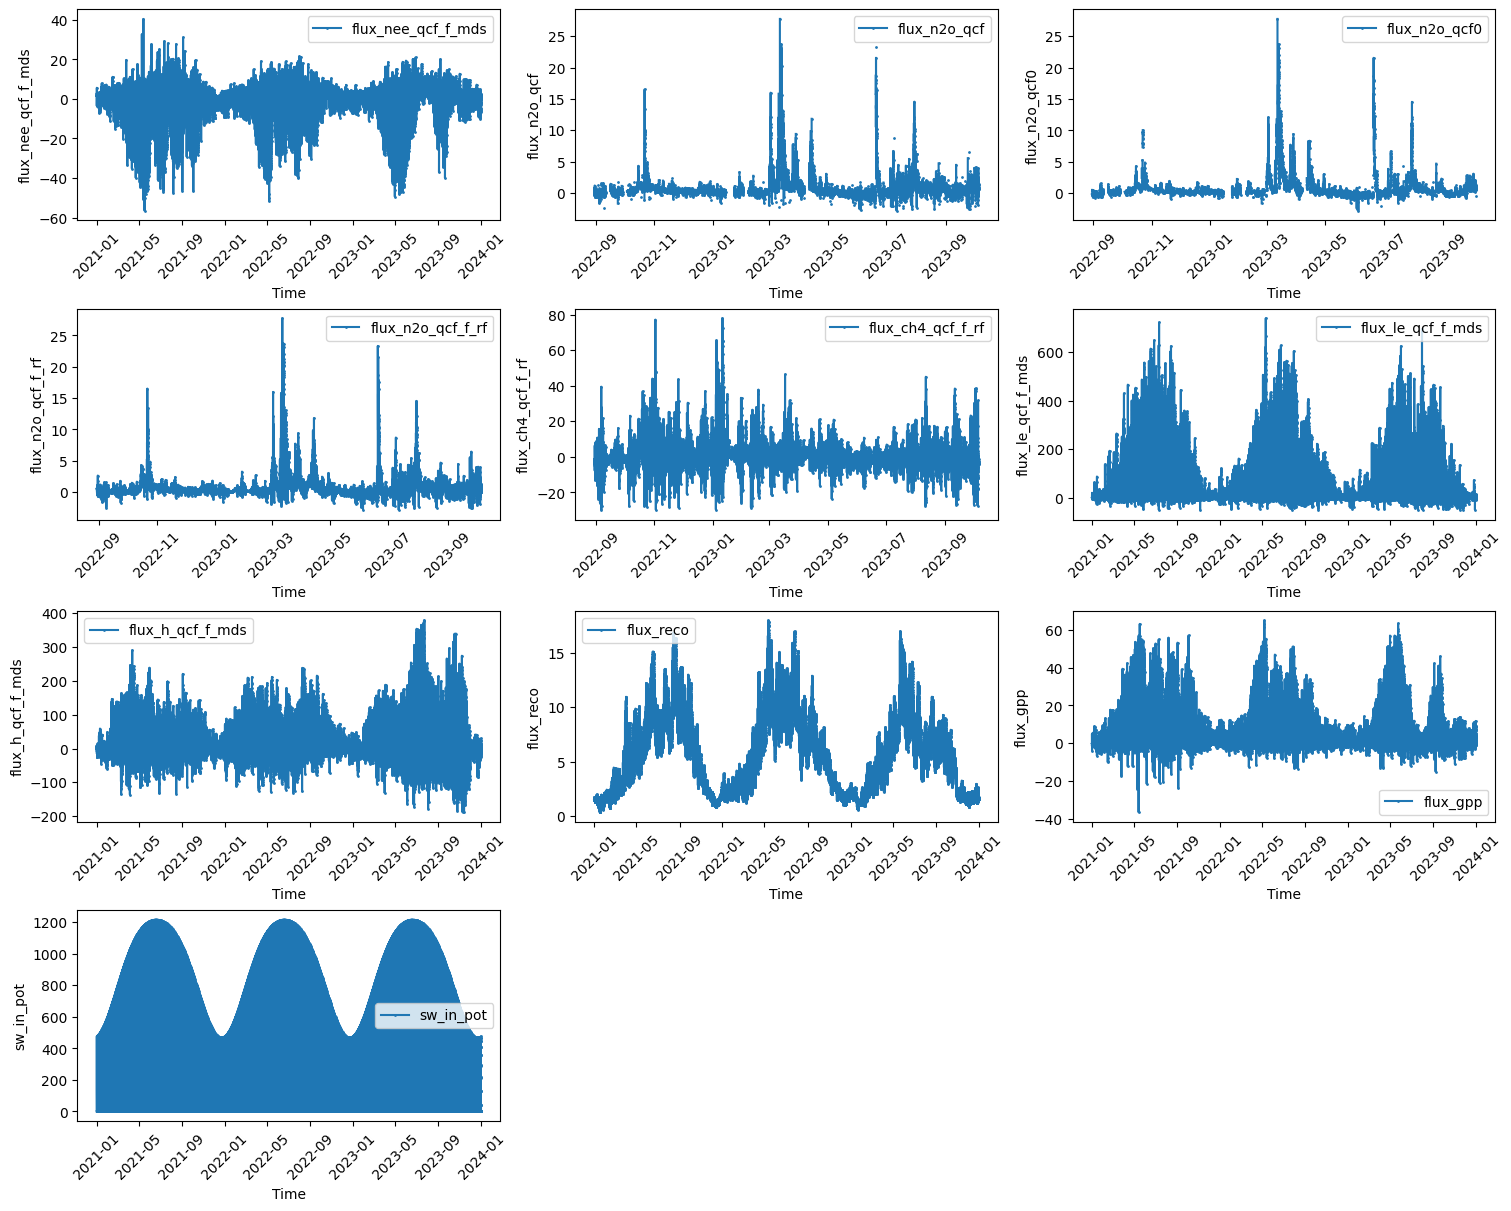

,flux_nee_qcf_f_mds,flux_n2o_qcf,flux_n2o_qcf0,flux_n2o_qcf_f_rf,flux_ch4_qcf_f_rf,flux_le_qcf_f_mds,flux_h_qcf_f_mds,flux_reco,flux_gpp,sw_in_pot
timestamp_middle,,,,,,,,,,
2020-12-31 23:15:00,1.531928,NaN,NaN,NaN,NaN,1.313335,1.188433,1.515735,-0.016194,NaN
2020-12-31 23:45:00,1.531928,NaN,NaN,NaN,NaN,1.301519,2.905173,1.514467,-0.017462,NaN
2021-01-01 00:15:00,1.531928,NaN,NaN,NaN,NaN,0.055464,-3.557021,1.514245,-0.017684,0.0
2021-01-01 00:45:00,1.531928,NaN,NaN,NaN,NaN,0.348332,-3.557021,1.515828,-0.016101,0.0
2021-01-01 01:15:00,1.531928,NaN,NaN,NaN,NaN,-0.038865,-3.557021,1.517995,-0.013933,0.0
...,...,...,...,...,...,...,...,...,...,...
2023-12-31 21:45:00,1.370211,NaN,NaN,NaN,NaN,-0.853410,-5.293847,1.626682,0.256471,0.0
2023-12-31 22:15:00,0.593252,NaN,NaN,NaN,NaN,-1.187178,-3.587753,1.684758,1.091506,0.0
2023-12-31 22:45:00,1.295956,NaN,NaN,NaN,NaN,-0.409499,-6.293662,1.756364,0.460408,0.0


In [4]:
fluxes = dataframes['fluxes']

# Rename column names so all lower case, no spaces or special characters
fluxes.columns = fluxes.columns.str.lower().str.replace(' ', '_').str.replace(r'[^a-zA-Z0-9_]', '')

# Select variables we want to keep
cols = ['timestamp_middle', 
#        'nee_l3.1_l3.3_cut_50_qcf',
#        'nee_l3.1_l3.3_cut_50_qcf0',
        'nee_u50_f_reddyproc',
        'fn2o_l3.1_l3.3_cut_50_qcf',
        'fn2o_l3.1_l3.3_cut_50_qcf0',
        'fn2o_l3.1_l3.3_cut_50_qcf_gfrf',
#        'fch4_l3.1_l3.3_cut_50_qcf',
#        'fch4_l3.1_l3.3_cut_50_qcf0',
        'fch4_l3.1_l3.3_cut_50_qcf_gfrf',
#        'le_l3.1_l3.3_cut_none_qcf',
#        'le_l3.1_l3.3_cut_none_qcf0',
        'le_f_reddyproc',
#        'h_l3.1_l3.3_cut_none_qcf',
#        'h_l3.1_l3.3_cut_none_qcf0',
        'h_f_reddyproc',
        'reco_u50_reddyproc',
        'gpp_u50_f_reddyproc',
        'sw_in_pot' # add also potential incoming shortwave radiation
        ]
fluxes = fluxes[cols].copy()

rename_dict = {
        # 'nee_l3.1_l3.3_cut_50_qcf': 'flux_nee_qcf',
        # 'nee_l3.1_l3.3_cut_50_qcf0': 'flux_nee_qcf0',
        'nee_u50_f_reddyproc': 'flux_nee_qcf_f_mds',
        'fn2o_l3.1_l3.3_cut_50_qcf': 'flux_n2o_qcf',
        'fn2o_l3.1_l3.3_cut_50_qcf0': 'flux_n2o_qcf0',
        'fn2o_l3.1_l3.3_cut_50_qcf_gfrf': 'flux_n2o_qcf_f_rf',
        # 'fch4_l3.1_l3.3_cut_50_qcf': 'flux_ch4_qcf',
        # 'fch4_l3.1_l3.3_cut_50_qcf0': 'flux_ch4_qcf0',
        'fch4_l3.1_l3.3_cut_50_qcf_gfrf': 'flux_ch4_qcf_f_rf',
        # 'le_l3.1_l3.3_cut_none_qcf': 'flux_le_qcf',
        # 'le_l3.1_l3.3_cut_none_qcf0': 'flux_le_qcf0',
        'le_f_reddyproc': 'flux_le_qcf_f_mds',
        # 'h_l3.1_l3.3_cut_none_qcf': 'flux_h_qcf',
        # 'h_l3.1_l3.3_cut_none_qcf0': 'flux_h_qcf0',
        'h_f_reddyproc': 'flux_h_qcf_f_mds',
        'reco_u50_reddyproc': 'flux_reco',
        'gpp_u50_f_reddyproc': 'flux_gpp'   
}

# Apply the renaming dictionary
fluxes.rename(columns=rename_dict, inplace=True)

# Convert timestamp to datetime and set it as index
fluxes['timestamp_middle'] = pd.to_datetime(fluxes['timestamp_middle'], errors='coerce')
fluxes.set_index('timestamp_middle', inplace=True)

# plots
plot_data_grid(fluxes, ncols=3)
fluxes

## METEO

Bulk density data used for WFPS calculation was found in Emmel 2018 supplementary information:
https://www.research-collection.ethz.ch/handle/20.500.11850/260058

Specifically I used CH-Oe2.2017-05-31.SoilBulkDensity.csv contained in CH-Oe2.SoilVariables.zip

Excluded these variables: ['g_1', 'g_2', 'g_3', 'g_4', 'ppfd_dif', 'ppfd_in', 'ts_0.015_1', 'ts_0.015_2', 'ts_0.015_3', 'ts_0.015_4', 'ws', 'sw_out', 'lw_in', 'lw_out']
Found duplicates in index: 0
Found NaTs in index: 0


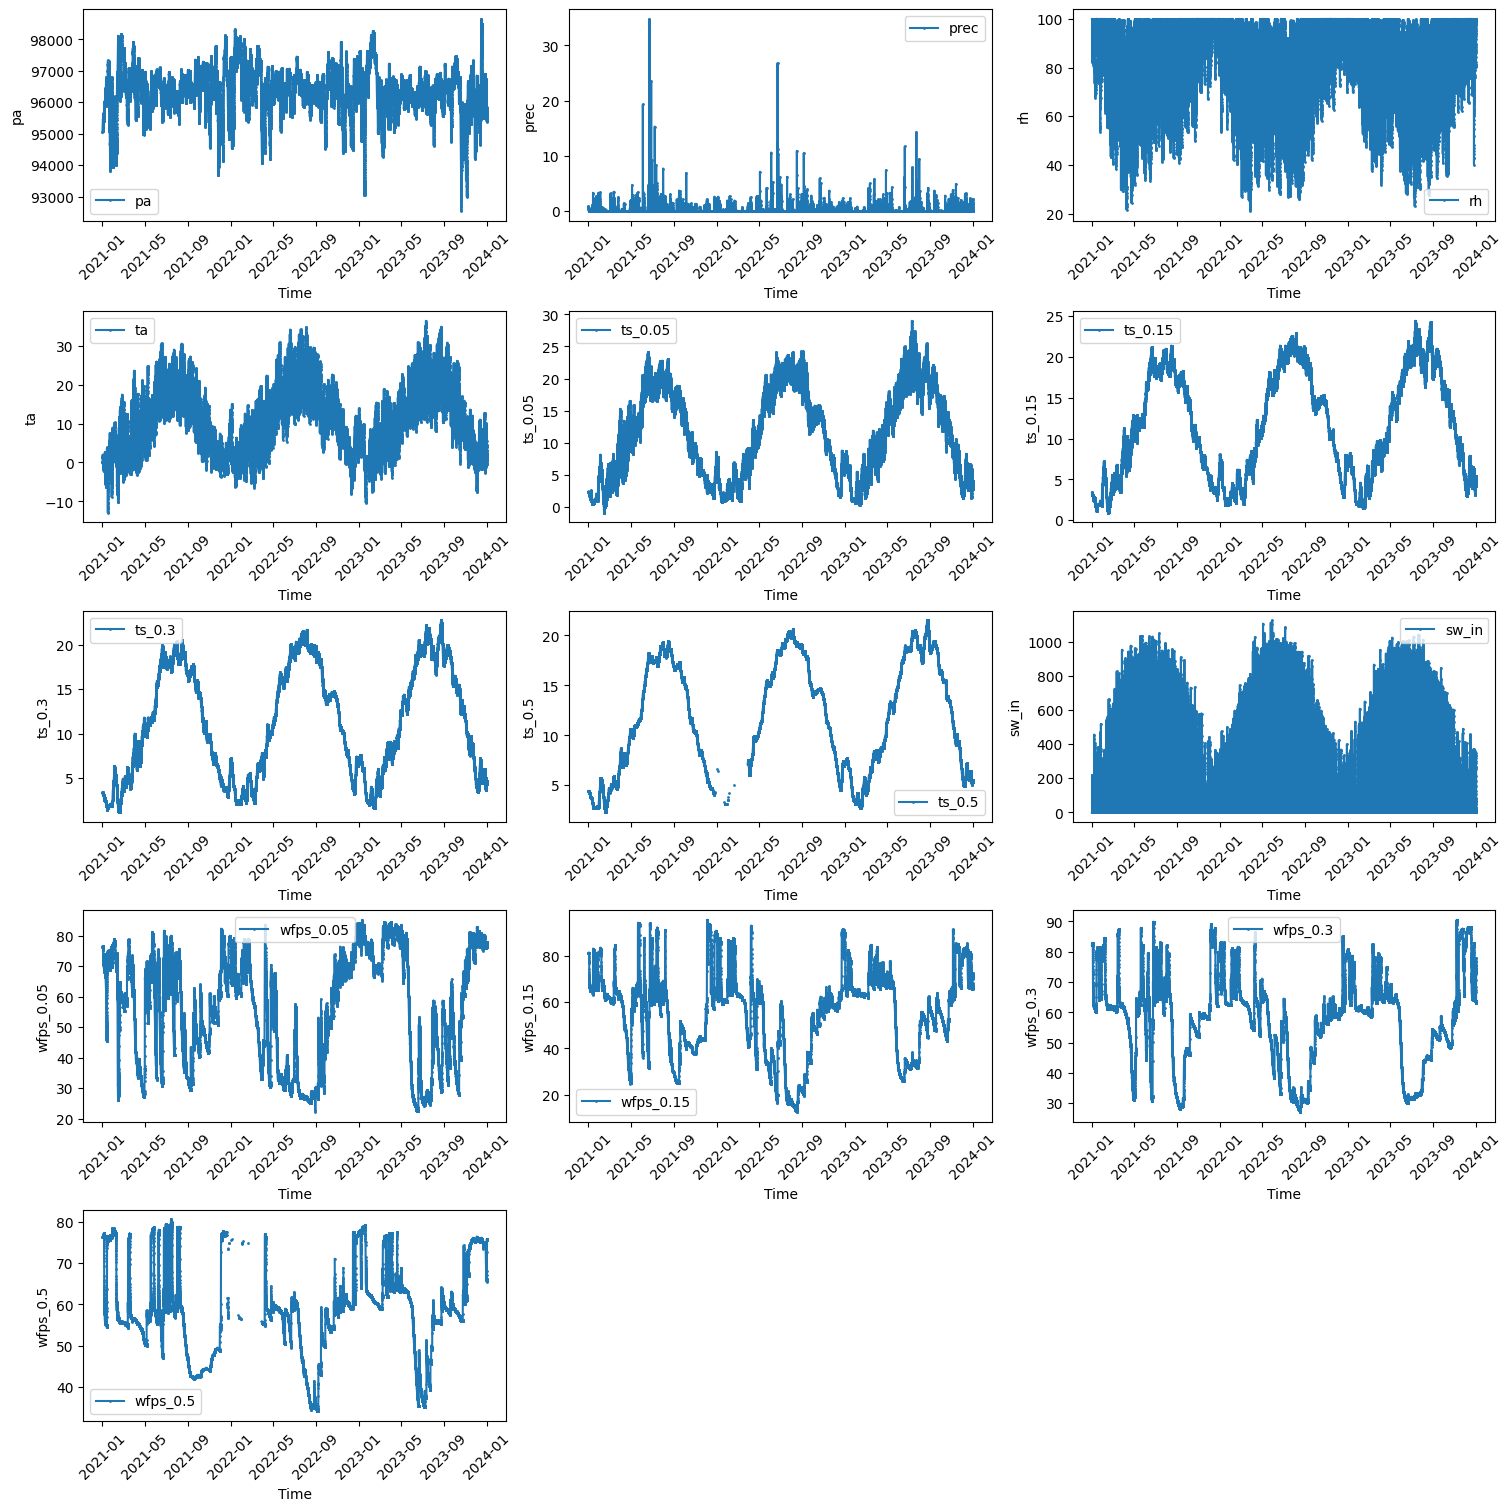

,pa,prec,rh,ta,ts_0.05,ts_0.15,ts_0.3,ts_0.5,sw_in,wfps_0.05,wfps_0.15,wfps_0.3,wfps_0.5
timestamp_middle,,,,,,,,,,,,,
2021-01-01 00:15:00,95063.620000,0.4,99.997990,0.098506,2.396667,3.395555,3.337778,4.452778,0.0,76.096681,81.146259,82.230222,76.320766
2021-01-01 00:45:00,95064.982000,0.7,99.997990,0.086844,2.375000,3.398889,3.350556,4.453333,0.0,76.121143,81.163727,82.238792,76.323646
2021-01-01 01:15:00,95072.237667,0.8,99.997990,0.084800,2.353889,3.393333,3.347778,4.452222,0.0,76.132649,81.175749,82.256491,76.336986
2021-01-01 01:45:00,95077.748000,0.9,99.997990,0.099361,2.313333,3.383333,3.345000,4.451667,0.0,76.135594,81.187572,82.252095,76.315749
2021-01-01 02:15:00,95092.707667,0.6,99.997990,0.119289,2.301667,3.376667,3.351111,4.453889,0.0,76.149786,81.223604,82.270907,76.329400
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 21:45:00,95673.459333,0.0,99.997990,1.049906,3.201111,4.400556,4.400556,5.303333,0.0,77.784746,71.000678,73.660001,75.844499
2023-12-31 22:15:00,95761.961000,0.0,99.997990,1.368644,3.104444,4.400000,4.400000,5.302222,0.0,77.788344,70.756401,73.114642,75.858318
2023-12-31 22:45:00,95773.584667,0.1,99.997990,1.713433,3.099444,4.400000,4.400556,5.300000,0.0,77.724713,70.541678,73.296967,75.847840


In [5]:
meteo = dataframes['meteo'].copy()

# Rename column names so all lower case, no spaces or special characters
meteo.columns = meteo.columns.str.lower().str.replace(' ', '_').str.replace(r'[^a-zA-Z0-9_]', '')
# Convert timestamp to datetime type and set it as index
meteo['timestamp_middle'] = pd.to_datetime(meteo['timestamp_middle'], format='%Y-%m-%dT%H:%M:%SZ', errors='coerce')
meteo.set_index('timestamp_middle', inplace=True)

# Aggregate by mean the repetitions of G and TS_0.015
# meteo['soil_heat_flux'] = np.nanmean(meteo[['g_1', 'g_2', 'g_3', 'g_4']], axis=1)
# meteo = meteo.drop(['g_1', 'g_2', 'g_3', 'g_4'], axis=1)
# meteo['ts_0.015'] = np.nanmean(meteo[['ts_0.015_1', 'ts_0.015_2', 'ts_0.015_3', 'ts_0.015_4']], axis=1)
# meteo = meteo.drop(['ts_0.015_1', 'ts_0.015_2', 'ts_0.015_3', 'ts_0.015_4'], axis=1)

# Remove soil heat flux, 0.015 soil temp and outgoing radiation
cols = ['ts_0.015', 'g_', 'sw_out', 'lw_', 'ws', 'ppfd']
to_remove = [c for c in meteo.columns if c.startswith(tuple(cols))]
meteo.drop(columns=to_remove, inplace=True)
print(f'Excluded these variables: {to_remove}')

# Calculate WFPS from SWC using formula with bulk density and particle density
# BD data from Emmel 2018
bulk_density = {
    '0.05': 1.16, # BD measured for 0-5 cm soil depth
    '0.15': 1.28, # BD as average of 0-5 and 15-30 cm soil depths
    '0.3': 1.365, # BD as average of 15-30 and 30-50 cm soil depths
    '0.5': 1.275  # BD as average of 30-50 and 50-70 cm soil depths
}
# Standard particle density since it was not measured
particle_density = 2.65
# Iterate over SWC columns and compute WFPS
swc_cols = [col for col in meteo if 'swc_' in col]
for col in swc_cols:
    new_name = col.replace('swc', 'wfps')
    for depth, bd in bulk_density.items():
        if depth in col:
            # calculate wfps for current depth
            wfps = meteo[col] / (1 - (bd / particle_density)) # no need to multiply by 100 because swc is in percent
            meteo[new_name] = wfps
            break

# Now we can remove all the swc columns from which we calculated wfps
meteo.drop(columns=swc_cols, inplace=True)

# Remove also the column stating the source of PREC data
meteo.drop(columns='prec_source', inplace=True)

# Remove duplicates, keep first
locs_duplicates = meteo.index.duplicated(keep='first')
print(f"Found duplicates in index: {locs_duplicates.sum()}")
meteo = meteo[~locs_duplicates]
# Remove NaTs
locs_nats = meteo.index.isnull()
print(f"Found NaTs in index: {locs_nats.sum()}")
meteo = meteo[~locs_nats]
# Sort timestamp index
meteo = meteo.sort_index(ascending=True)

# plots
plot_data_grid(meteo, ncols=3)

# show data
meteo

## LAI, CANOPY HEIGHT, BIOMASS

Found duplicates in index of lai: 0
Found NaTs in index of lai: 0
Found duplicates in index of canopy_height: 0
Found NaTs in index of canopy_height: 0
Found duplicates in index of crop_biomass: 0
Found NaTs in index of crop_biomass: 0
                          lai
timestamp_middle             
2022-06-25 12:15:00  0.300000
2022-06-25 12:45:00  0.303531
2022-06-25 13:15:00  0.307062
2022-06-25 13:45:00  0.310593
2022-06-25 14:15:00  0.314122
                     can_height
timestamp_middle               
2022-06-25 12:15:00    5.000000
2022-06-25 12:45:00    5.017897
2022-06-25 13:15:00    5.035796
2022-06-25 13:45:00    5.053698
2022-06-25 14:15:00    5.071602
                       crop_n    crop_c
timestamp_middle                       
2022-06-25 12:15:00  0.000000  0.000000
2022-06-25 12:45:00  0.095487  1.477978
2022-06-25 13:15:00  0.190884  2.954557
2022-06-25 13:45:00  0.286190  4.429737
2022-06-25 14:15:00  0.381406  5.903519


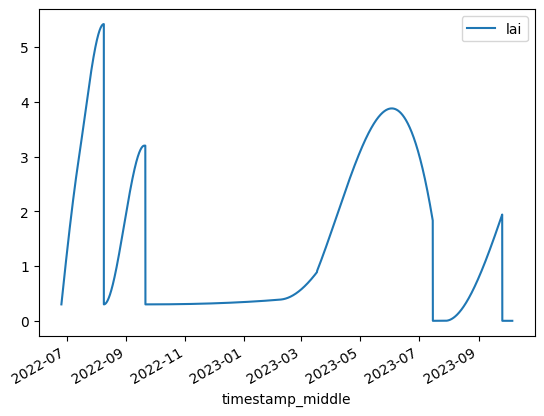

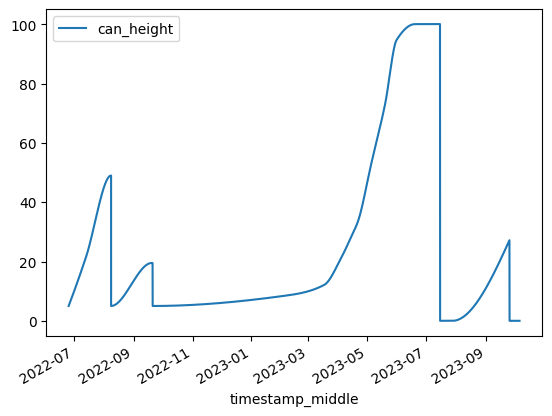

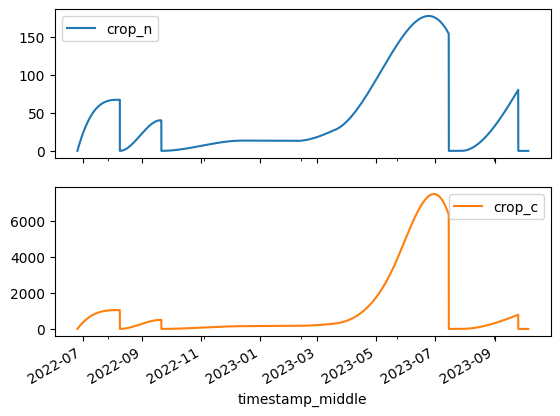

In [6]:
# LAI
lai = dataframes['lai'].copy()
# convert to datetime
lai['timestamp_middle'] = pd.to_datetime(lai['timestamp'], errors='coerce')
lai.drop(columns='timestamp', inplace=True)
lai.set_index('timestamp_middle', inplace=True) # set timestamp as index

# Remove duplicates, keep first
locs_duplicates = lai.index.duplicated(keep='first')
print(f"Found duplicates in index of lai: {locs_duplicates.sum()}")
lai = lai[~locs_duplicates]

# Remove NaTs
locs_nats = lai.index.isnull()
print(f"Found NaTs in index of lai: {locs_nats.sum()}")
lai = lai[~locs_nats]

# Sort timestamp index
lai = lai.sort_index(ascending=True)

# CANOPY HEIGHT
canopy_height = dataframes['canopy_height'].copy()
# convert to datetime
canopy_height['timestamp_middle'] = pd.to_datetime(canopy_height['timestamp'], errors='coerce')
canopy_height.rename({'can_height':'canopy_height'}, inplace=True)
canopy_height.drop(columns='timestamp', inplace=True)
canopy_height.set_index('timestamp_middle', inplace=True) # set timestamp as index

# Remove duplicates, keep first
locs_duplicates = canopy_height.index.duplicated(keep='first')
print(f"Found duplicates in index of canopy_height: {locs_duplicates.sum()}")
canopy_height = canopy_height[~locs_duplicates]

# Remove NaTs
locs_nats = canopy_height.index.isnull()
print(f"Found NaTs in index of canopy_height: {locs_nats.sum()}")
canopy_height = canopy_height[~locs_nats]

# Sort timestamp index
canopy_height = canopy_height.sort_index(ascending=True)

# C and N BIOMASS
crop_biomass = dataframes['crop_biomass'].copy()
# convert to datetime
crop_biomass['timestamp_middle'] = pd.to_datetime(crop_biomass['timestamp'], errors='coerce')
crop_biomass.drop(columns='timestamp', inplace=True)
crop_biomass.set_index('timestamp_middle', inplace=True) # set timestamp as index

# Remove duplicates, keep first
locs_duplicates = crop_biomass.index.duplicated(keep='first')
print(f"Found duplicates in index of crop_biomass: {locs_duplicates.sum()}")
crop_biomass = crop_biomass[~locs_duplicates]

# Remove NaTs
locs_nats = crop_biomass.index.isnull()
print(f"Found NaTs in index of crop_biomass: {locs_nats.sum()}")
crop_biomass = crop_biomass[~locs_nats]

# Sort timestamp index
crop_biomass = crop_biomass.sort_index(ascending=True)

print(lai.head())
print(canopy_height.head())
print(crop_biomass.head())

# check with a plot
lai.plot(x_compat=True);
canopy_height.plot(x_compat=True);
crop_biomass.plot(x_compat=True, subplots=True);

## MANAGEMENT

### EXTRACT INFO

Kg of N per hectar for liquid manure fertilizations are calculated according to 2024 values from the slurry samples taken by Francesco Argento on 02.04.2024 

*1.08 kg N per m3 of liquid manure (mean of 1.04 and 1.12)*

(Christoff Ammann measurements in 2010 indicated 1.5 kg N per m3)



Kg of N per hectar for solid manure fertilizations are calculated according to 2010 values -> see in CH-OE2.Management.allyears.xlsx

*0.006 kg of N per kg of solid manure*

In [7]:
management = dataframes['management'].copy() # Make an explicit copy to avoid potential slice issues

# reset the header to the correct row
new_header = management.iloc[0].str.lower().str.replace(' ', '_').str.replace(r'[^a-zA-Z0-9_]', '')
management = management[1:]
management.columns = new_header
management.reset_index(drop=True, inplace=True)

# convert date to datetime and set to timestamp middle format
management['timestamp_middle'] = pd.to_datetime(management['dateyear'] + 'T12:15', format='%d.%m.%YT%H:%M', errors='coerce')

# Create the 'operation' column to identify the type of operation
management['operation'] = management[['management_subcategory', 'management_specific']].apply(
    lambda x: ' '.join(x.dropna()), axis=1)
# Replace empty strings with NaN
management['operation'] = management['operation'].replace('', np.nan)
# Fill remaining NaN values with 'management_category'
management['operation'] = management['operation'].fillna(management['management_category'])
# Strip any whitespace from the resulting strings
management['operation'] = management['operation'].str.strip().replace(' ', '_', regex=True)

# Convert 'amount/ha' and 'n_kg/ha' to numeric
management['amount/ha'] = pd.to_numeric(management['amount/ha'], errors='coerce')
management['n_kg/ha'] = pd.to_numeric(management['n_kg/ha'], errors='coerce')

# Calculate the kg of N per hectar for the fertilizations
# for slurry
management.loc[
    (management['management_subcategory'] == 'manure') & (management['management_specific'] == 'liquid'),
    'n_kg/ha'
] = management['amount/ha'] * 1.08
# for solid manure
management.loc[
    (management['management_subcategory'] == 'manure') & (management['management_specific'] == 'solid'),
    'n_kg/ha'
] = management['amount/ha'] * 0.006

# show how the dataframe looks like
management[['timestamp_middle', 'management_category', 'management_subcategory', 'management_specific', 'amount/ha', 'n_kg/ha', 'crop_type']]

,timestamp_middle,management_category,management_subcategory,management_specific,amount/ha,n_kg/ha,crop_type
0,2021-01-12 12:15:00,fertilization,manure,solid,NaN,NaN,grass
1,2021-02-26 12:15:00,fertilization,mineral,Mg-Ammonsalpeter,100.0,27.0,grass
2,2021-03-03 12:15:00,fertilization,manure,liquid,25.0,27.0,grass
3,2021-05-30 12:15:00,harvest,second cut,harvester,NaN,NaN,grass
4,2021-06-01 12:15:00,harvest,straw harvest,NaN,13548.0,NaN,grass
5,2021-06-04 12:15:00,fertilization,manure,liquid,25.0,27.0,grass
6,2021-07-20 12:15:00,harvest,third cut,harvester,NaN,NaN,grass
7,2021-07-21 12:15:00,harvest,straw harvest,NaN,8709.0,NaN,grass
8,2021-07-27 12:15:00,fertilization,manure,liquid,25.0,27.0,grass
9,2021-09-02 12:15:00,harvest,fourth cut,harvester,NaN,NaN,grass


Transform the dataframe in a complete time series

Note:

- Glyphosate application and direct seeding are assigned to the soil preparation category:
    - Glyphosate terminated the grassland -> same effect on plants of a tillage
    - Direct seeding cut the soil to create the hole for the seeds -> sort of tillage

- **ACHTUNG: No distinction between organic and mineral fertilization because in this dataset the only organic fertilization was applied the day after the mineral fertilization so it is impossible to disentagle the effects of the two types**

### 0/1 DATAFRAME

Found duplicates in index: 0
Found NaTs in index: 0


,operation,fert,harvest,sowing,soil_preparation,mgmt,nitrogen_fert,crop_type
timestamp_middle,,,,,,,,
2021-01-12 12:15:00,manure_solid,1,0,0,0,1,NaN,grass
2021-01-12 12:45:00,NaN,0,0,0,0,0,0.0,grass
2021-01-12 13:15:00,NaN,0,0,0,0,0,0.0,grass
2021-01-12 13:45:00,NaN,0,0,0,0,0,0.0,grass
2021-01-12 14:15:00,NaN,0,0,0,0,0,0.0,grass
...,...,...,...,...,...,...,...,...
2023-10-05 10:15:00,NaN,0,0,0,0,0,0.0,wbarley
2023-10-05 10:45:00,NaN,0,0,0,0,0,0.0,wbarley
2023-10-05 11:15:00,NaN,0,0,0,0,0,0.0,wbarley


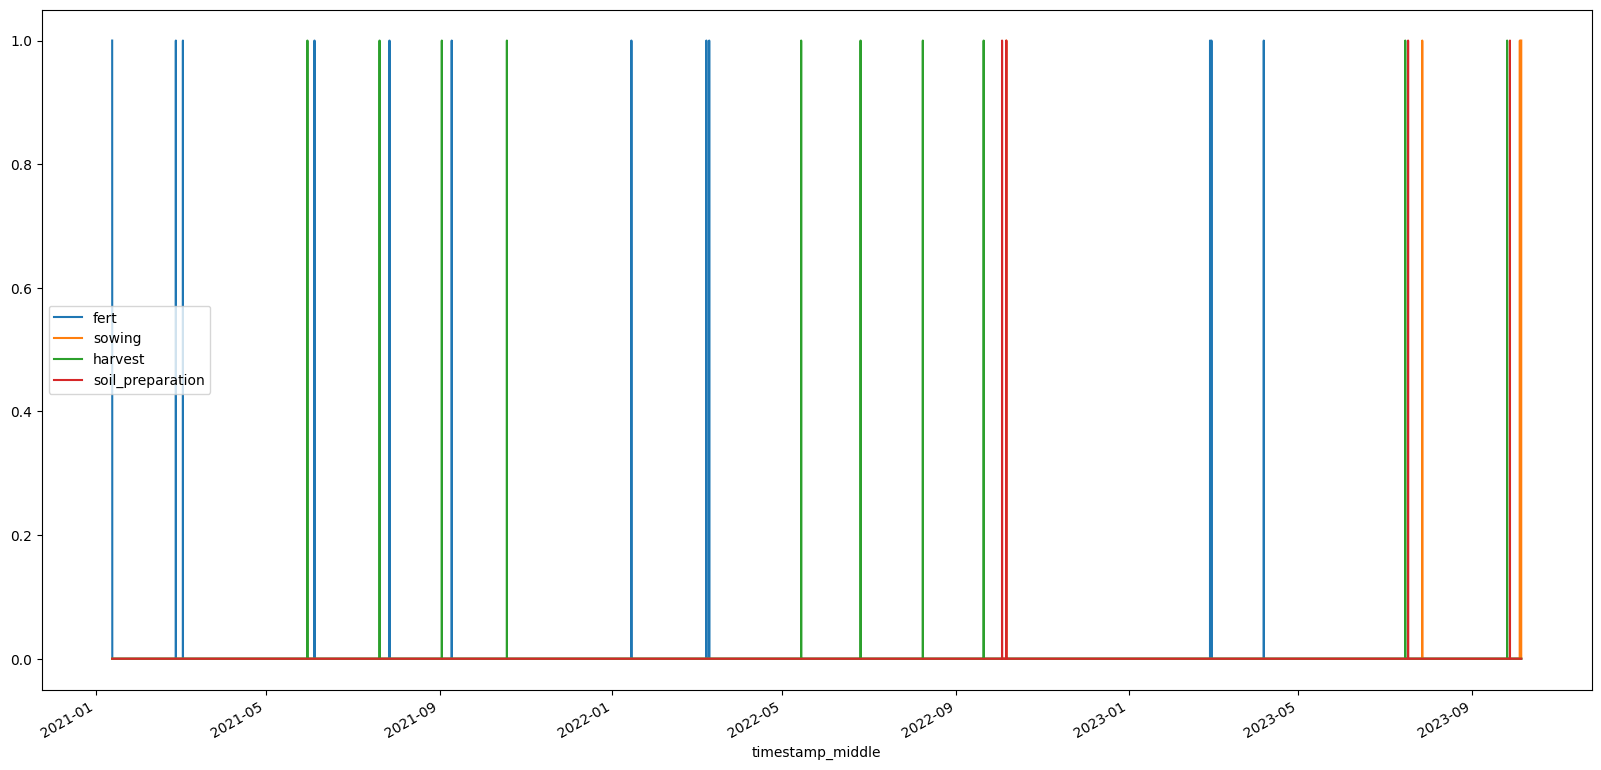

In [8]:
# Create a complete timestamp from 2021 to 2023, every 30 minutes
start_date = management['timestamp_middle'].min()
end_date = management['timestamp_middle'].max()
timestamps = pd.date_range(start=start_date, end=end_date, freq='30min')

# Create a new dataframe with the management events as columns
mgmt = pd.DataFrame({
    'timestamp_middle': timestamps,
    'fert': 0,
    'harvest': 0,
    'sowing': 0,
    'soil_preparation': 0,
    'nitrogen_fert' : 0
})

# Merge with the management DataFrame
mgmt = pd.merge(mgmt, management, on='timestamp_middle', how='left')

# Define the event to be 1 on the day when it was conducted
mgmt.loc[mgmt['management_category'] == 'fertilization', 'fert'] = 1
mgmt.loc[(mgmt['management_category'] == 'harvest') & (~mgmt['management_specific'].isna()), 'harvest'] = 1
mgmt.loc[mgmt['management_category'] == 'sowing', 'sowing'] = 1
mgmt.loc[mgmt['management_category'] == 'cultivation', 'soil_preparation'] = 1
mgmt.loc[mgmt['management_specific'] == 'direct-seeding', 'soil_preparation'] = 1
mgmt.loc[mgmt['management_specific'] == 'Glyphosate', 'soil_preparation'] = 1
mgmt['nitrogen_fert'] = mgmt['nitrogen_fert'].astype('float64')
mgmt.loc[mgmt['management_category'] == 'fertilization', 'nitrogen_fert'] = mgmt['n_kg/ha']
mgmt['mgmt'] = mgmt['fert'] + mgmt['harvest'] + mgmt['sowing'] + mgmt['soil_preparation'] # add variable for combined management

# Select only columns we will use
mgmt = mgmt[['timestamp_middle', 'operation', 'fert', 'harvest', 'sowing', 'soil_preparation', 'mgmt', 'nitrogen_fert', 'crop_type']] 

# Fill nans in croptype
mgmt['crop_type'] = mgmt['crop_type'].ffill()

# Remove rows where none of the selected operations was conducted
mgmt = mgmt[~((mgmt['mgmt']==0) & (mgmt['operation'].notna()))]

# Set 'timestamp_middle' as the index of the DataFrame
mgmt.set_index('timestamp_middle', inplace=True)

# Remove duplicates, keep first
locs_duplicates = mgmt.index.duplicated(keep='first')
print(f"Found duplicates in index: {locs_duplicates.sum()}")
if sum(locs_duplicates) > 0:
    print(mgmt[locs_duplicates])
mgmt = mgmt[~locs_duplicates]

# Remove NaTs
locs_nats = mgmt.index.isnull()
print(f"Found NaTs in index: {locs_nats.sum()}")
mgmt = mgmt[~locs_nats]

# Sort timestamp index
mgmt = mgmt.sort_index(ascending=True)

# Plot the management events
mgmt[['fert', 'sowing', 'harvest', 'soil_preparation']].plot(figsize=(20,10), x_compat=True);

mgmt

### N FERT RESIDUE CALCULATION

#### LINEAR

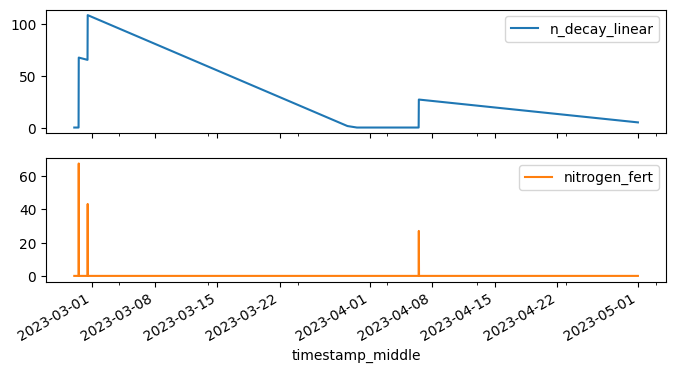

In [9]:
def compute_linear_decay(df, duration_steps=1440):
    df = df.copy()
    decay_col = 'n_decay_linear'
    df[decay_col] = 0.0

    for timestamp, row in df.iterrows():
        fert = row['nitrogen_fert']
        if pd.notna(fert) and fert > 0:
            i = df.index.get_loc(timestamp)  # get integer position
            for offset in range(duration_steps):
                idx = i + offset
                if idx < len(df):
                    decay_value = fert - offset * (fert / duration_steps)
                    if decay_value > 0:
                        df.iloc[idx, df.columns.get_loc(decay_col)] += decay_value
    return df


mgmt = compute_linear_decay(mgmt)

# Plot the new engineered feature
indat = mgmt[['n_decay_linear', 'nitrogen_fert']].dropna()
indat = indat.loc['2023-02-27':'2023-04-30']
indat.plot(figsize=(8, 4), x_compat=True, subplots=True)
plt.show()

#### LOGISTIC

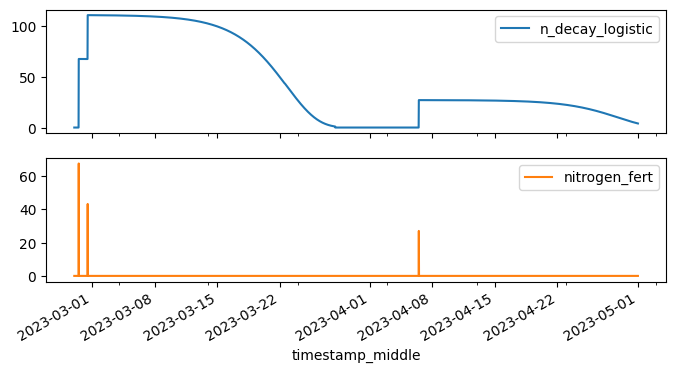

In [10]:
# Replace 0 with NaN in a copy of the column, then assign back
mgmt['n_decay_logistic'] = mgmt['nitrogen_fert'].replace(0, np.nan)

# Function to fill NaNs using a logistic decay with optimized parameters
def fill_logistic_decay(series, k=0.5, t0=10):
    """
    Fill NaNs in a series using logistic decay. The decay starts from the last valid value,
    and residuals from incomplete decays are added to subsequent starting points.
    """
    series = series.copy()
    last_value = None  # Tracks the last valid value
    residual = 0  # Tracks the remaining residual for the next decay
    time_step = 0  # Tracks the time step since the last non-NaN value

    for i in range(len(series)):
        if pd.isna(series.iloc[i]):
            if last_value is not None:
                # Apply logistic decay formula to the residual
                decay_value = residual * (1 / (1 + np.exp(-k * (time_step - t0))))
                series.iloc[i] = decay_value
                residual = decay_value  # Update residual for further decay
                time_step += 1  # Increment time step
            else:
                series.iloc[i] = np.nan  # Leave as NaN if no previous valid value
        else:
            # When encountering a new non-NaN value
            # Add the residual to the current value and start a new decay
            series.iloc[i] += residual
            residual = series.iloc[i]  # Set residual to the current value
            last_value = series.iloc[i]  # Update last value
            time_step = 1  # Reset time step
    return series

# Optimized parameters for logistic decay using CHA 2013 data
k = -1.6 / 48  # multiplied by 48 because the parameter is dependent on time and it was optimized for days
t0 = 3.5 * 48 

# Visually optimized to my dataset
t0 = 40 * 48
k = -0.006  # moderate decay rate (decays over ~10 days) 

# Apply the logistic decay function to fill NaNs
mgmt['n_decay_logistic'] = fill_logistic_decay(mgmt['n_decay_logistic'], k, t0)

# Ensure no NaNs or values lower than 1
mgmt['n_decay_logistic'] = mgmt['n_decay_logistic'].fillna(1)
mgmt.loc[mgmt['n_decay_logistic'] < 1, 'n_decay_logistic'] = 0

# Plot the new engineered feature
indat = mgmt[['n_decay_logistic', 'nitrogen_fert']].dropna()
indat = indat.loc['2023-02-27':'2023-04-30']
indat.plot(figsize=(8, 4), x_compat=True, subplots=True)
plt.show()

#### EXPONENTIAL

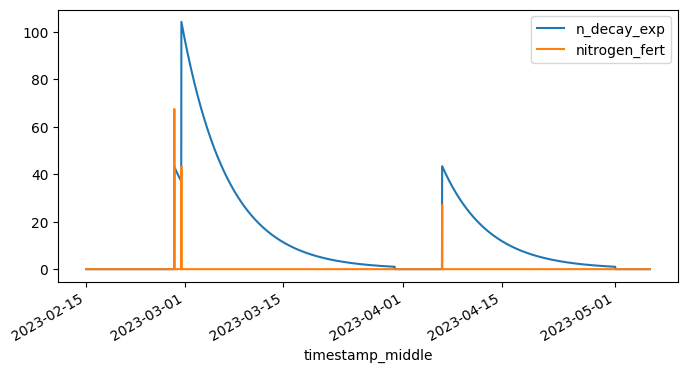

In [11]:
# Replace 0 with NaN in a copy of the column, then assign back
mgmt['n_decay_exp'] = mgmt['nitrogen_fert'].replace(0, np.nan)

# Function to fill NaNs with an exponential decline from the last known value + previous decay residuals
def fill_exponential_decline(series, decay_factor=0.9985):
    # Work on a copy of the series to avoid modifying the original DataFrame directly
    series = series.copy()
    last_value = None
    residual = 0
    for i in range(len(series)):
        if pd.isna(series.iloc[i]):
            if last_value is not None:
                residual *= decay_factor
                series.iloc[i] = residual
            else:
                series.iloc[i] = np.nan
        else:
            if last_value is not None:
                residual = last_value * decay_factor + residual * decay_factor
            else:
                residual = series.iloc[i]
            last_value = series.iloc[i]
            series.iloc[i] += residual - series.iloc[i]
    return series

# Target: decay from 100 to ~1 in 1440 steps (30 days)
decay_factor = np.exp(np.log(1 / 100) / 1440)  # ≈ 0.996805

# Apply the function to fill NaNs
mgmt['n_decay_exp'] = fill_exponential_decline(mgmt['n_decay_exp'], decay_factor=decay_factor)

# Ensure no NaNs or values lower than 1
mgmt['n_decay_exp'] = mgmt['n_decay_exp'].fillna(1)
mgmt.loc[mgmt['n_decay_exp'] < 1, 'n_decay_exp'] = 0

# Plot the new engineered feature
indat = mgmt[['n_decay_exp', 'nitrogen_fert']].dropna()
indat = indat.loc['2023-02-15':'2023-05-05']
indat.plot(figsize=(8, 4), x_compat=True);

#### LOGNORMAL

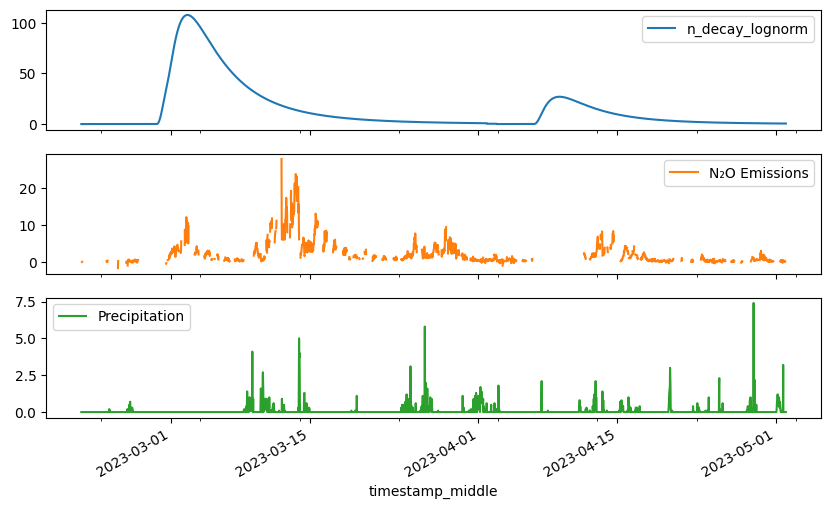

In [12]:
# Lognormal decay generator ---
def generate_lognormal_decay_series(fert_series, mu, sigma, duration=1600):
    index = fert_series.index
    fert_series = fert_series.fillna(0).to_numpy()
    decay_result = np.zeros_like(fert_series)

    t = np.arange(1, duration + 1)
    kernel = lognorm.pdf(t, s=sigma, scale=np.exp(mu))
    kernel = kernel / kernel.max()  # scale so peak = 1

    for i, val in enumerate(fert_series):
        if val > 0:
            end = min(i + duration, len(fert_series))
            decay_result[i:end] += val * kernel[:end - i]

    return pd.Series(decay_result, index=index)

# Define mu and sigma visually
opt_mu = 5.5
opt_sigma = 0.8

# Generate decay and plot ---
mgmt['n_decay_lognorm'] = generate_lognormal_decay_series(mgmt['nitrogen_fert'], opt_mu, opt_sigma)

(mgmt['n_decay_lognorm']
 .to_frame()
 .join(fluxes['flux_n2o_qcf0'])
 .join(meteo['prec'])
 .loc['2023-02-20':'2023-05-01']
 .rename(columns={'flux_n2o_qcf0': 'N₂O Emissions', 'prec': 'Precipitation'})
 .plot(subplots=True, figsize=(10, 6), legend=True));

#### TIMED

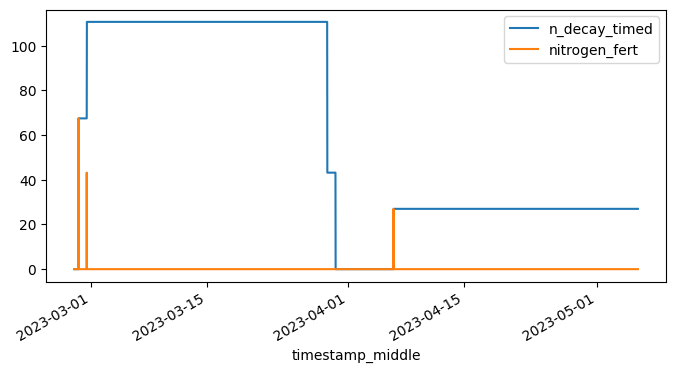

In [13]:
# Define different durations for organic and mineral fertilization
organic_duration = 30   # days for manure/organic
mineral_duration = 30   # days for mineral

# Function to handle independent fertilization events
def n_decay_timing(df):
    df = df.copy()
    df['n_decay_timed'] = 0.0
    df = df.sort_index()

    for idx, row in df.iterrows():
        fert = row['nitrogen_fert']
        if pd.notna(fert) and fert > 0:
            op = str(row['operation']).lower()
            duration = organic_duration if op.startswith("manure") else mineral_duration if op.startswith("mineral") else 0
            if duration > 0:
                end_time = idx + pd.Timedelta(days=duration)
                df.loc[(df.index > idx) & (df.index <= end_time), 'n_decay_timed'] += fert
    return df['n_decay_timed']

# Apply the function
mgmt['n_decay_timed'] = n_decay_timing(mgmt)

# Ensure no NaNs remain
mgmt['n_decay_timed'] = mgmt['n_decay_timed'].fillna(0)

# Plot the new engineered feature
indat = mgmt[['n_decay_timed', 'nitrogen_fert']].dropna()
indat = indat.loc['2023-02-27':'2023-05-05']
indat.plot(figsize=(8, 4), x_compat=True);


## PRS NUTRIENTS

Found duplicates in index: 0
Found NaTs in index: 0


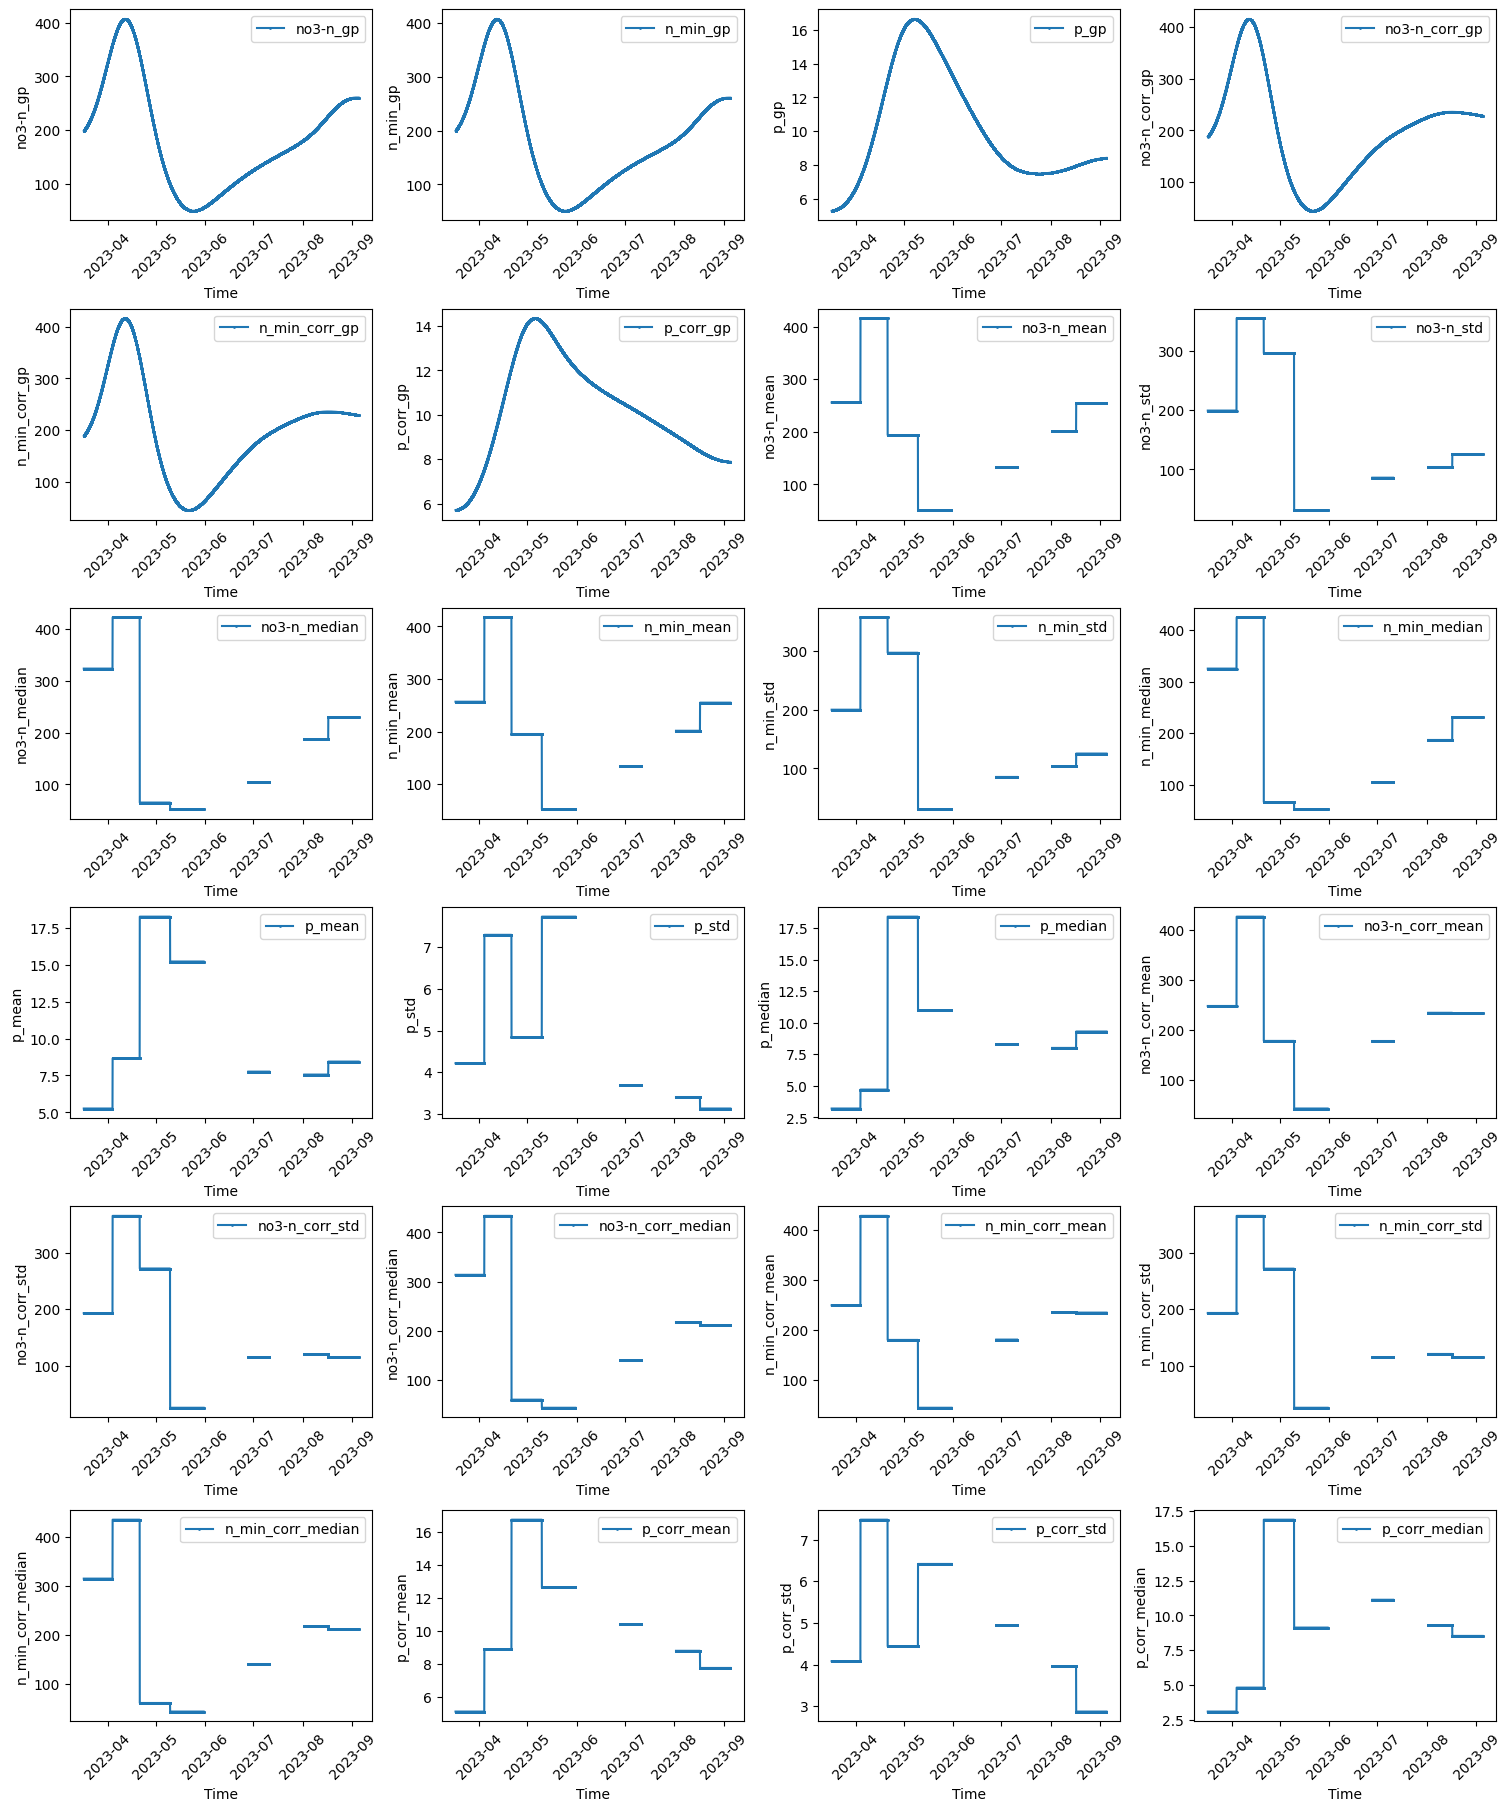

,no3-n_gp,n_min_gp,p_gp,no3-n_corr_gp,n_min_corr_gp,p_corr_gp,no3-n_mean,no3-n_std,no3-n_median,n_min_mean,...,p_median,no3-n_corr_mean,no3-n_corr_std,no3-n_corr_median,n_min_corr_mean,n_min_corr_std,n_min_corr_median,p_corr_mean,p_corr_std,p_corr_median
timestamp_middle,,,,,,,,,,,,,,,,,,,,,
2023-03-17 00:15:00,198.839718,199.694588,5.295702,188.125570,188.925061,5.710252,256.0,199.506892,324.0,256.8,...,3.2,247.873016,193.173340,313.714286,248.647619,193.319367,314.682540,5.093016,4.081969,3.098413
2023-03-17 00:45:00,198.922005,199.776851,5.296036,188.207354,189.006879,5.710496,256.0,199.506892,324.0,256.8,...,3.2,247.873016,193.173340,313.714286,248.647619,193.319367,314.682540,5.093016,4.081969,3.098413
2023-03-17 01:15:00,199.004530,199.859352,5.296373,188.289399,189.088958,5.710742,256.0,199.506892,324.0,256.8,...,3.2,247.873016,193.173340,313.714286,248.647619,193.319367,314.682540,5.093016,4.081969,3.098413
2023-03-17 01:45:00,199.087292,199.942091,5.296712,188.371706,189.171298,5.710991,256.0,199.506892,324.0,256.8,...,3.2,247.873016,193.173340,313.714286,248.647619,193.319367,314.682540,5.093016,4.081969,3.098413
2023-03-17 02:15:00,199.170293,200.025068,5.297055,188.454276,189.253900,5.711243,256.0,199.506892,324.0,256.8,...,3.2,247.873016,193.173340,313.714286,248.647619,193.319367,314.682540,5.093016,4.081969,3.098413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-04 22:15:00,260.606729,261.179614,8.423622,228.442031,228.988950,7.885230,254.6,125.382614,230.0,255.0,...,9.3,233.542857,115.012624,210.977444,233.909774,114.905395,211.894737,7.741955,2.872022,8.530827
2023-09-04 22:45:00,260.604154,261.177306,8.423782,228.429985,228.977173,7.885120,254.6,125.382614,230.0,255.0,...,9.3,233.542857,115.012624,210.977444,233.909774,114.905395,211.894737,7.741955,2.872022,8.530827
2023-09-04 23:15:00,260.601516,261.174936,8.423942,228.417938,228.965393,7.885011,254.6,125.382614,230.0,255.0,...,9.3,233.542857,115.012624,210.977444,233.909774,114.905395,211.894737,7.741955,2.872022,8.530827


In [14]:
nutrients_prs = dataframes['nutrients_prs']
nutrients_prs['timestamp_middle'] = pd.to_datetime(nutrients_prs['dt'], format='%Y-%m-%d %H:%M:%S') + timedelta(minutes=15)
nutrients_prs = nutrients_prs.drop('dt', axis=1)
nutrients_prs.set_index('timestamp_middle', inplace=True)

# Remove duplicates, keep first
locs_duplicates = nutrients_prs.index.duplicated(keep='first')
print(f"Found duplicates in index: {locs_duplicates.sum()}")
nutrients_prs = nutrients_prs[~locs_duplicates]

# Remove NaTs
locs_nats = nutrients_prs.index.isnull()
print(f"Found NaTs in index: {locs_nats.sum()}")
nutrients_prs = nutrients_prs[~locs_nats]

# Sort timestamp index
nutrients_prs = nutrients_prs.sort_index(ascending=True)

# show the plot of interpolated and averaged no3-
plot_data_grid(nutrients_prs, ncols=4)

# show the dataframe
nutrients_prs

## N UPTAKE

In [15]:
# n_uptake = dataframes['n_uptake']
# n_uptake['timestamp_middle'] = pd.to_datetime(n_uptake['timestamp_middle'], format='%Y-%m-%d %H:%M:%S') 
# n_uptake.set_index('timestamp_middle', inplace=True)
# n_uptake

### CALCULATE N BALANCE

In [16]:
# # Merge the datasets
# df_merge = pd.concat([mgmt, n_uptake], axis=1)

# # Ensure 'crop_n_uptake' has no NaNs and is non-negative
# df_merge['crop_n_uptake'] = df_merge['crop_n_uptake'].fillna(0)
# df_merge.loc[df_merge['crop_n_uptake'] < 0, 'crop_n_uptake'] = 0

# # Create a new column for nitrogen balance
# df_merge['n_balance'] = df_merge['n_decay_timed'].copy()

# # Iterate over DataFrame using the DatetimeIndex instead of positional indexing
# prev_idx = df_merge.index[0]  # Start with the first index
# for curr_idx in df_merge.index[1:]:  
#     # Check if `n_decay_timed` has changed → Reset `n_balance`
#     if df_merge.loc[curr_idx, 'n_decay_timed'] != df_merge.loc[prev_idx, 'n_decay_timed']:
#         df_merge.loc[curr_idx, 'n_balance'] = df_merge.loc[curr_idx, 'n_decay_timed']
#     else:
#         # Subtract crop nitrogen uptake while ensuring balance doesn't go negative
#         df_merge.loc[curr_idx, 'n_balance'] = max(
#             df_merge.loc[prev_idx, 'n_balance'] - df_merge.loc[curr_idx, 'crop_n_uptake'],
#             0
#         )
#     prev_idx = curr_idx  # Update previous index for next iteration

# # Plot the new engineered feature
# indat = df_merge.loc['2023-02-27':'2023-05-05', ['crop_n_uptake', 'n_balance', 'n_decay_timed']]
# indat.plot(figsize=(8, 4), x_compat=True, subplots=True);

# MERGE DATA

Merge data

In [17]:
df = pd.concat([fluxes, meteo, lai, canopy_height, crop_biomass, mgmt, nutrients_prs], axis=1)

# SANITIZE TIMESTAMP

In [18]:
# Remove duplicates, keep first
locs_duplicates = df.index.duplicated(keep='first')
print(f"Found duplicates in index: {locs_duplicates.sum()}")
df = df[~locs_duplicates]

# Remove NaTs
locs_nats = df.index.isnull()
print(f"Found NaTs in index: {locs_nats.sum()}")
df = df[~locs_nats]

# Sort timestamp index
df = df.sort_index(ascending=True)

df

Found duplicates in index: 0
Found NaTs in index: 0


,flux_nee_qcf_f_mds,flux_n2o_qcf,flux_n2o_qcf0,flux_n2o_qcf_f_rf,flux_ch4_qcf_f_rf,flux_le_qcf_f_mds,flux_h_qcf_f_mds,flux_reco,flux_gpp,sw_in_pot,...,p_median,no3-n_corr_mean,no3-n_corr_std,no3-n_corr_median,n_min_corr_mean,n_min_corr_std,n_min_corr_median,p_corr_mean,p_corr_std,p_corr_median
timestamp_middle,,,,,,,,,,,,,,,,,,,,,
2020-12-31 23:15:00,1.531928,NaN,NaN,NaN,NaN,1.313335,1.188433,1.515735,-0.016194,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-31 23:45:00,1.531928,NaN,NaN,NaN,NaN,1.301519,2.905173,1.514467,-0.017462,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 00:15:00,1.531928,NaN,NaN,NaN,NaN,0.055464,-3.557021,1.514245,-0.017684,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 00:45:00,1.531928,NaN,NaN,NaN,NaN,0.348332,-3.557021,1.515828,-0.016101,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 01:15:00,1.531928,NaN,NaN,NaN,NaN,-0.038865,-3.557021,1.517995,-0.013933,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 21:45:00,1.370211,NaN,NaN,NaN,NaN,-0.853410,-5.293847,1.626682,0.256471,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-31 22:15:00,0.593252,NaN,NaN,NaN,NaN,-1.187178,-3.587753,1.684758,1.091506,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-31 22:45:00,1.295956,NaN,NaN,NaN,NaN,-0.409499,-6.293662,1.756364,0.460408,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# RESAMPLE

In [19]:
# save a copy of the 30min data
df_30min = df.copy()

Define the aggregation methods for the variables

In [20]:
# Define default aggregation
default_agg = 'mean'

# List of columns with specific aggregation functions
sum_agg = {col: 'sum' for col in df.columns if col == 'prec' or col == 'nitrogen_fert' or 'crop_n_uptake' in col} # columns aggregated by sum
print('Sum aggregation will be used for the following variables \n', sum_agg.keys())
max_cols = ['fert', 'harvest', 'sowing', 'soil_preparation', 'mgmt'] # columns aggregated by max
max_agg = {col: 'max' for col in max_cols} 
print('Max aggregation will be used for the following variables \n', max_agg.keys())
string_columns = df.select_dtypes(include=['object']).columns.tolist() # find string columns if any
print("String variables for which no aggregation can be conducted:\n", string_columns)

# Create the agg_funcs dictionary
agg_funcs = {col: default_agg for col in df.columns}
agg_funcs.update(sum_agg) # add sum aggregations
agg_funcs.update(max_agg) # add max aggregations

Sum aggregation will be used for the following variables 
 dict_keys(['prec', 'nitrogen_fert'])
Max aggregation will be used for the following variables 
 dict_keys(['fert', 'harvest', 'sowing', 'soil_preparation', 'mgmt'])
String variables for which no aggregation can be conducted:
 ['operation', 'crop_type']


Function to aggregate based on the previously defined aggregation dictionary and also setting a minimum sample size for the aggregation

In [21]:
# Function to filter groups based on minimum size and apply aggregations
def filter_and_aggregate(group, min_records, agg_funcs):
    aggregated_data = {}
    for col, agg_func in agg_funcs.items():
        if col in string_columns:
            # Always aggregate string columns without considering min_records
            aggregated_data[col] = group[col].dropna().iloc[0] if not group[col].dropna().empty else np.nan
        else:
            # Apply the min_records requirement for numeric columns
            if group[col].count() >= min_records:
                aggregated_data[col] = group[col].agg(agg_func)
            else:
                aggregated_data[col] = np.nan
    return pd.Series(aggregated_data)

#### DAILY

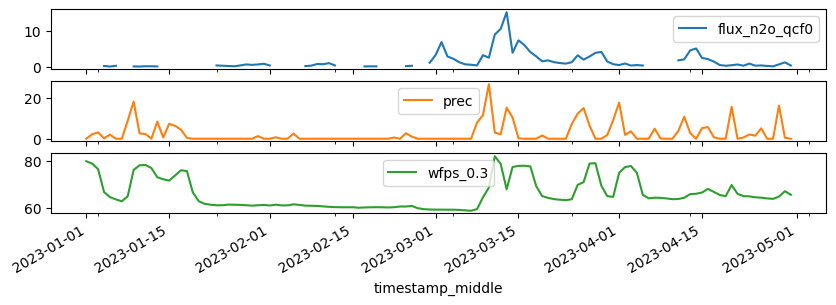

In [22]:
# Define the minimum number of records required for aggregation
min_records = 6
# Resample
df_24h = df.resample('D').apply(lambda x: filter_and_aggregate(x, min_records, agg_funcs))
# Plot of aggregated DataFrame
indat = df_24h['2023-01-01':'2023-04-30'][['flux_n2o_qcf0', 'prec', 'wfps_0.3']].copy()
indat.plot(x_compat=True, subplots=True, figsize=(10, len(indat.columns)));

#### 8-HOURLY

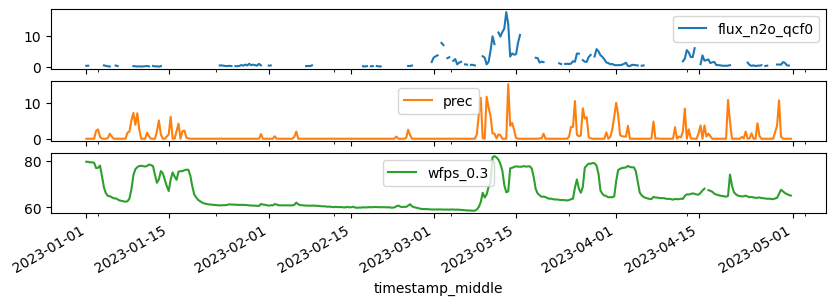

In [23]:
# Define the minimum number of records required for aggregation
min_records = 4
# Resample
df_8h = df.resample('8h').apply(lambda x: filter_and_aggregate(x, min_records, agg_funcs))
# Plot of aggregated DataFrame
indat = df_8h['2023-01-01':'2023-04-30'][['flux_n2o_qcf0', 'prec', 'wfps_0.3']].copy()
indat.plot(x_compat=True, subplots=True, figsize=(10, len(indat.columns)));

#### 4-HOURLY

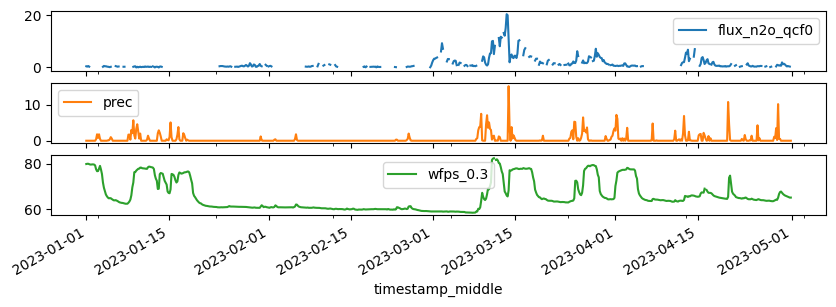

In [24]:
# Define the minimum number of records required for aggregation
min_records = 2
# Resample
df_4h = df.resample('4h').apply(lambda x: filter_and_aggregate(x, min_records, agg_funcs))
# Plot of aggregated DataFrame
indat = df_4h['2023-01-01':'2023-04-30'][['flux_n2o_qcf0', 'prec', 'wfps_0.3']].copy()
indat.plot(x_compat=True, subplots=True, figsize=(10, len(indat.columns)));

Map the dataframes to a dictionary

In [25]:
# Map dataframes to names in a dictionary
dfs = {
    '0.5h': df_30min,
    '4h': df_4h,
    '8h': df_8h,
    '24h': df_24h
}

# CREATE ADDITIONAL VARIABLES

## TIME SINCE VARIABLES
Count time (records) since last occurrence, e.g. time since last precipitation.

Variables for which timesince will be calculated:

In [26]:
_list_timesince_vars = ['prec', 'soil_preparation', 'harvest', 'sowing', 'fert']

New df to assemble timesince, will be merged with main data later

In [27]:
_timesince_df = pd.DataFrame()

Function to calculate timesince:

In [28]:
def timesince(series, time_resolution):
    """
    Compute time since last nonzero event using a group-based approach, considering a user-defined time resolution.

    Args:
    - series (pd.Series): Time series with a DatetimeIndex.
    - time_resolution (float): Time resolution in hours (e.g., 0.5 for 30 min, 1 for hourly, etc.).

    Returns:
    - pd.Series: Series counting time since last event, in days, capped at 30 days.
    """

    # Ensure index is a DatetimeIndex
    if not isinstance(series.index, pd.DatetimeIndex):
        raise ValueError("Series index must be a DatetimeIndex.")

    # Convert time resolution to fraction of a day
    step_size = time_resolution / 24  # Convert hours to fraction of a day

    # Create a flag: 1 for zeros, 0 for nonzero values
    flag = series.copy()
    flag.loc[series > 0] = 0  # Reset counter when positive values appear
    flag.loc[series == 0] = 1  # Set flag to 1 where series = 0
    flag.loc[series.isnull()] = 1  # Treat NaNs as zeros

    # Identify groups where zero sequences start
    group = (flag != flag.shift()).cumsum()

    # Count steps within each group
    time_since_event = flag * (flag.groupby(group).cumcount() + 1)

    # Convert to days based on given resolution
    days_since_event = np.ceil(time_since_event * step_size).astype(int)

    # **Cap at 30 days** (without keeping previous max values)
    days_since_event = days_since_event.clip(1, 30)

    return days_since_event

Calculate timesince variables:

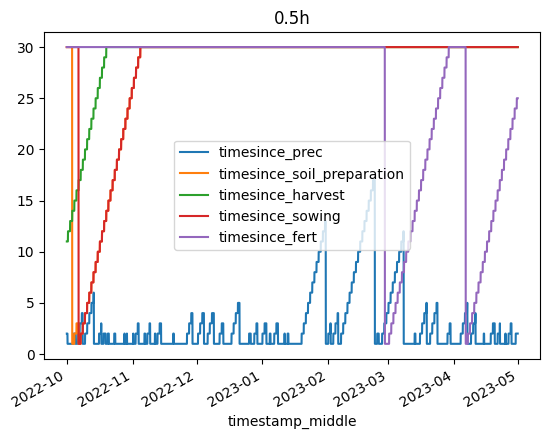

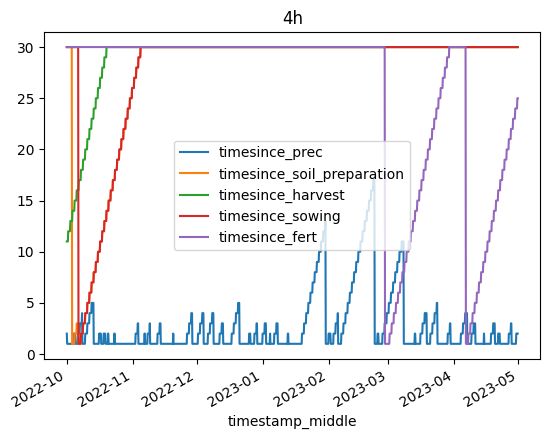

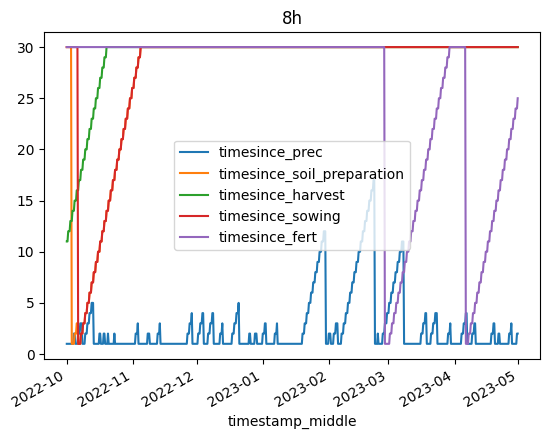

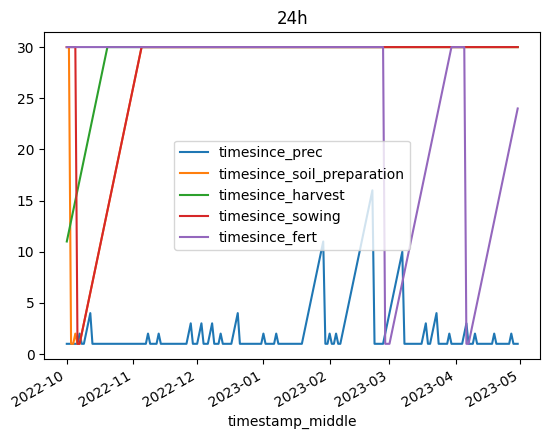

In [29]:
# Loop through each dataframe
for name, df in dfs.items():

    # Retrieve df time res
    time_res = float(name.replace('h', ''))

    # Prepare a list to hold the new variants
    timesince_columns = []

    # Copy relevant columns
    for v in _list_timesince_vars:
        if v in df.columns:
            _timesince_df[v] = df[v].copy()        

    # Calculate timesince for selected vars
        var_timesince = f'timesince_{v}'   
        timesince_columns.append(timesince(series=df[v], time_resolution=time_res).rename(var_timesince))

    # Concatenate all new columns
    _timesince_data = pd.concat(timesince_columns, axis=1)

    # Add only the timesince columns to the original dataframe
    dfs[name] = pd.concat([df, _timesince_data], axis=1)

    # Plot the timesince variables for the selected period
    indat = dfs[name][[c for c in dfs[name].columns if 'timesince' in c]]
    indat = indat.loc['2022-10-01':'2023-04-30']
    indat.plot(x_compat=True, title=name);

## BINARY TIMED

Variables for which timesince will be calculated:

In [30]:
_list_binary_timed_vars = ['soil_preparation', 'harvest', 'sowing', 'fert']

New df to assemble timesince, will be merged with main data later

In [31]:
def timed_mask(series, time_resolution):
    """
    Create a binary variable that is 1 for up to 30 days after a nonzero event, 0 otherwise.

    Args:
    - series (pd.Series): Time series with a DatetimeIndex.
    - time_resolution (float): Time resolution in hours.

    Returns:
    - pd.Series: Binary mask indicating recent event activity (1 if ≤ 30 days since event).
    """
    if not isinstance(series.index, pd.DatetimeIndex):
        raise ValueError("Series index must be a DatetimeIndex.")

    step_size = time_resolution / 24  # fraction of a day

    flag = series.copy()
    flag.loc[series > 0] = 0
    flag.loc[series == 0] = 1
    flag.loc[series.isnull()] = 1

    group = (flag != flag.shift()).cumsum()
    time_since_event = flag * (flag.groupby(group).cumcount() + 1)
    days_since_event = np.ceil(time_since_event * step_size).astype(int)

    return (days_since_event <= 30).astype(int)

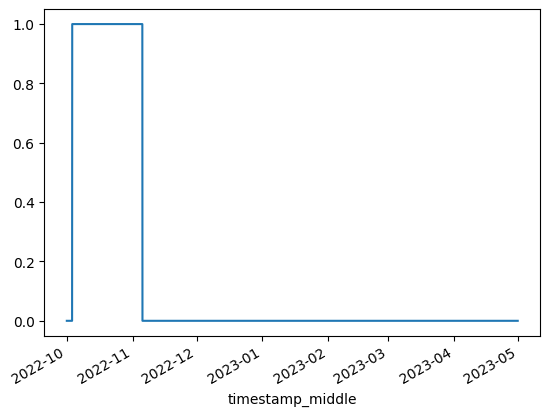

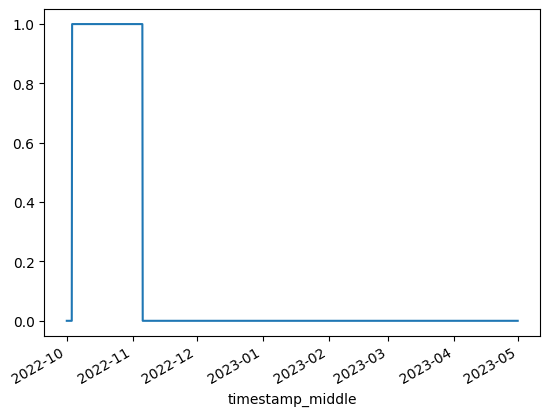

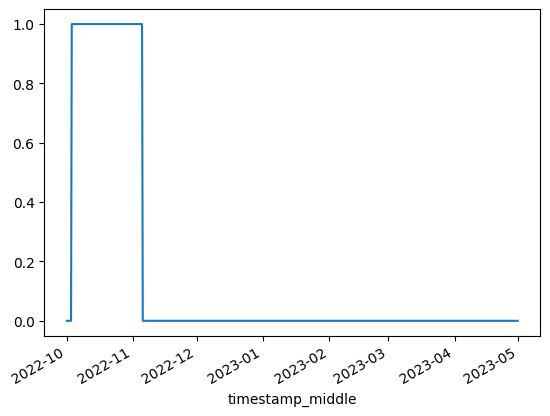

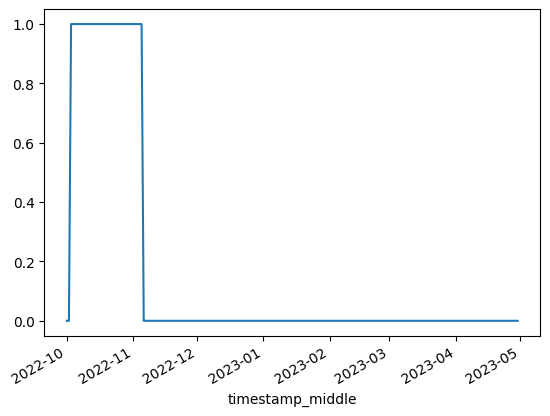

In [32]:
for name, df in dfs.items():

    time_res = float(name.replace('h', ''))

    # Store new timed columns here
    timed_columns = []

    for v in _list_binary_timed_vars:
        if v in df.columns:
            _timed_col = f'{v}_timed'
            timed_mask_col = timed_mask(series=df[v], time_resolution=time_res).rename(_timed_col)
            timed_columns.append(timed_mask_col)

    # Concatenate and add to original df
    _timed_data = pd.concat(timed_columns, axis=1)
    dfs[name] = pd.concat([df, _timed_data], axis=1)

    # Plot the _timed variables
    indat = dfs[name]['soil_preparation_timed']
    indat = indat.loc['2022-10-01':'2023-04-30']
    indat.plot(x_compat=True)
    plt.show()

## LAGGED VARIANTS

Variables for which lagged variants will be calculated:

In [33]:
# Define columns of interest
_list_lag_vars = list(meteo.columns) + list(fluxes.columns)
_list_lag_vars

['pa',
 'prec',
 'rh',
 'ta',
 'ts_0.05',
 'ts_0.15',
 'ts_0.3',
 'ts_0.5',
 'sw_in',
 'wfps_0.05',
 'wfps_0.15',
 'wfps_0.3',
 'wfps_0.5',
 'flux_nee_qcf_f_mds',
 'flux_n2o_qcf',
 'flux_n2o_qcf0',
 'flux_n2o_qcf_f_rf',
 'flux_ch4_qcf_f_rf',
 'flux_le_qcf_f_mds',
 'flux_h_qcf_f_mds',
 'flux_reco',
 'flux_gpp',
 'sw_in_pot']

Calculate the lagged variants

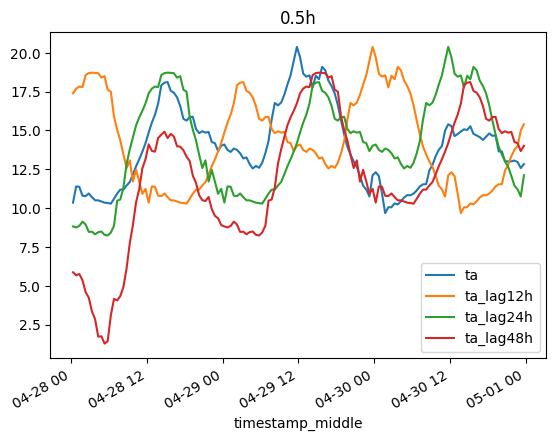

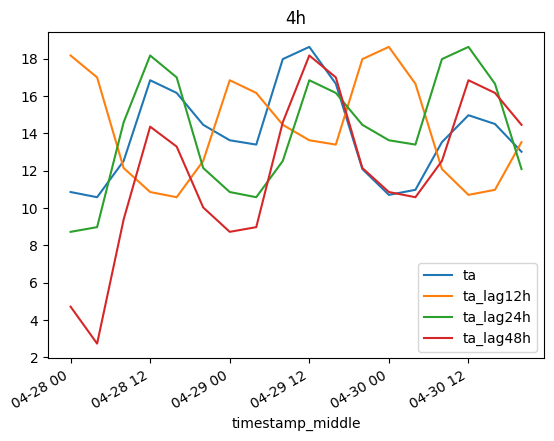

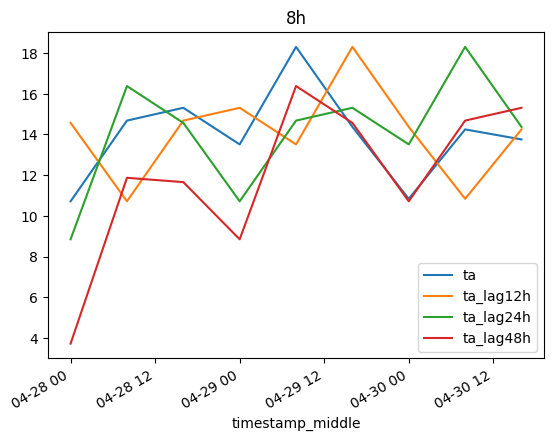

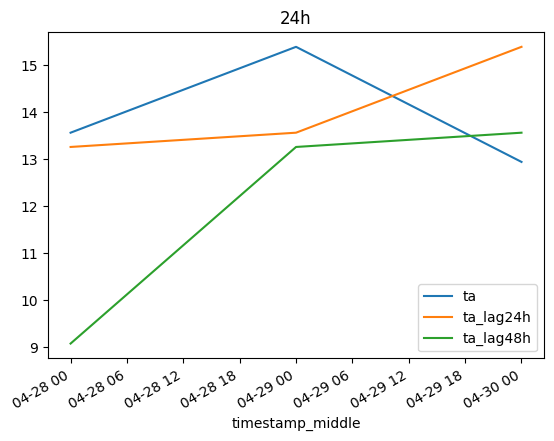

In [34]:
# Define which are the lags we want to apply
intervals = [12, 24, 48] # in hours

# Loop through the dictionary
for name, df in dfs.items():

    # Identify the time resolution in hours of the dataframe
    time_res = float(name.replace('h', ''))

    # Prepare a list to hold new lagged columns
    lagged_columns = []

    # Copy relevant columns
    for v in _list_lag_vars:
        if v in df.columns:       
            # Calculate lags for selected vars
            for lag in intervals:
                lag_adjusted = int(lag/time_res)
                if lag_adjusted > 0:
                    var_lag = f'{v}_lag{lag}h'
                    lagged_columns.append(df[v].shift(lag_adjusted).rename(var_lag)) 

    # Concatenate all lagged columns at once to avoid fragmentation
    _lag_data = pd.concat(lagged_columns, axis=1)

    # Add only the lag columns to the original dataframe
    dfs[name] = pd.concat([df, _lag_data], axis=1)

    # Plot the lag vars for TA
    indat = dfs[name][[c for c in dfs[name].columns if 'ta' in c and 'sum' not in c]]
    indat = indat.loc['2023-04-28':'2023-04-30']
    indat.plot(x_compat=True, title=name)  

## ROLLING VARIANTS

Calculate the rolling variants

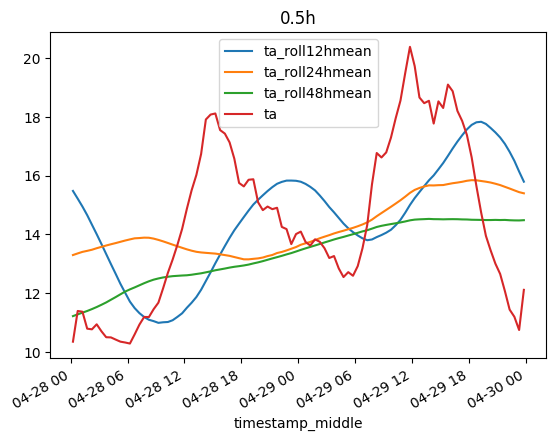

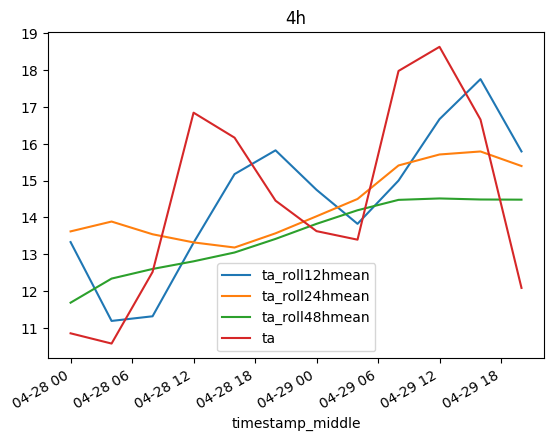

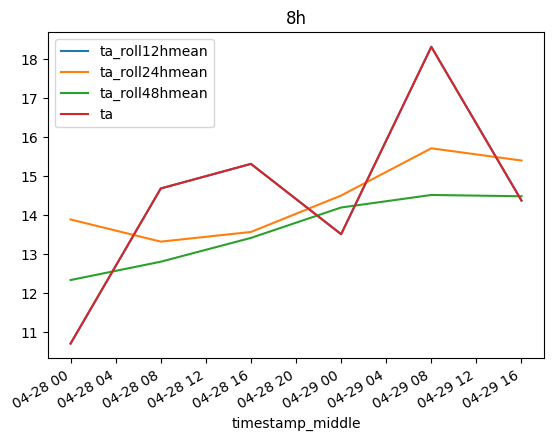

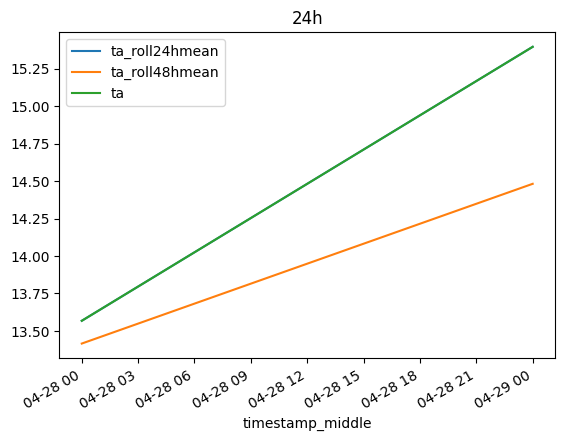

In [35]:
# Define the rolling intervals
intervals = [12, 24, 48] # in hours

# Define the type of aggregations we will apply
aggtypes_default = ['mean']
aggtypes_prec = ['sum']  # Apply 'sum' only to 'prec'

# Loop through the dictionary
for name, df in dfs.items():
    # Select the columns to be rolled
    _list_rolling_vars = [c for c in df.columns if c.startswith(tuple(_list_lag_vars)) and 'lag' not in c]
    # Identify the time resolution in hours of the dataframe
    time_res = float(name.replace('h', ''))
    # Prepare a list to hold new rolling columns
    roll_columns = []

    # Copy relevant columns
    for v in _list_rolling_vars:
        if v in df.columns:
            # Determine aggregation type
            aggtypes = aggtypes_prec if v.startswith(('prec', 'flux_gpp')) else aggtypes_default
            
            # Calculate rolling variants
            for interval in intervals:
                interval_adjusted = int(interval/time_res)
                if interval_adjusted > 0:
                    for agg in aggtypes:
                        var_roll = f'{v}_roll{interval}h{agg}'
                        roll_columns.append(df[v].rolling(interval_adjusted).agg(agg).rename(var_roll)) 

    # Concatenate all rolling columns at once to avoid fragmentation
    _roll_data = pd.concat(roll_columns, axis=1)

    # Add only the roll columns to the original dataframe
    dfs[name] = pd.concat([df, _roll_data], axis=1)

    # Plot the roll vars for TA excluding sum for visualization reasons
    cols = [c for c in dfs[name].columns if 'ta' in c and 'roll' in c] + ['ta']
    indat = dfs[name][cols]
    indat = indat.loc['2023-04-28':'2023-04-29']
    indat.plot(x_compat=True, title=name)

## N RESIDUE

In [36]:
# def get_n_residue(series, subtract_series, factor=800):
# #    Applies a decay-like process by assigning nitrogen fertilization values 
# #    and reducing them according to GPP flux cumulatively. Resets negative values to 0.
#     # Initialize residue series
#     n_residue = pd.Series(0.0, index=series.index)
    
#     for i, current_index in enumerate(series.index):
#         if i == 0:
#             # Set initial residue value based on nitrogen fertilization
#             n_residue.loc[current_index] = series.loc[current_index]
#         else:
#             # Calculate residue value for subsequent days
#             prev_index = series.index[i - 1]
#             n_residue.loc[current_index] = n_residue.loc[prev_index] + series.loc[current_index]
        
#         # Reduce by flux_gpp
#         n_residue.loc[current_index] -= subtract_series.loc[current_index] / factor
        
#         # Reset negative values to 0
#         if n_residue.loc[current_index] < 0:
#             n_residue.loc[current_index] = 0
    
#     return n_residue

In [37]:
# # Loop through each dataframe
# for name, df in dfs.items():
#     subtract_column = ['flux_gpp_roll24hsum']
#     n_column = ['nitrogen_fert']
#     df[subtract_column] = df[subtract_column].fillna(0)
#     df[n_column] = df[n_column].fillna(0)
#     df['n_residue'] = get_n_residue(df[n_column], df[subtract_column], factor=1000)
#     dfs[name] = df
#     # Plot the results
#     indat = df[['n_residue', 'nitrogen_fert']].dropna()
#     indat = indat['2023-02-26':'2023-05-05']
#     indat.plot(figsize=(8, 4), x_compat=True, subplots=True)
#     plt.suptitle(name)
#     plt.show()

## RATE OF CHANGE

Used for WFPS and TS

In [38]:
# define columns of interest
_list_diff_vars = [col for col in df.columns if ('ts' in col or 'wfps' in col or 'lai' in col or 'canopy_height' in col) and ('roll' not in col and 'lag' not in col)]

print(f'We calculate the rate of change for these variables: {_list_diff_vars}')

We calculate the rate of change for these variables: ['ts_0.05', 'ts_0.15', 'ts_0.3', 'ts_0.5', 'wfps_0.05', 'wfps_0.15', 'wfps_0.3', 'wfps_0.5', 'lai']


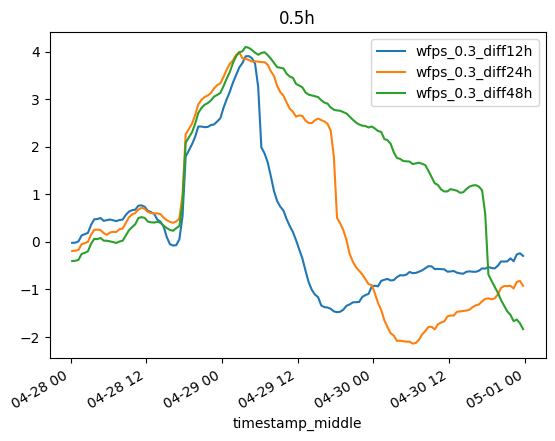

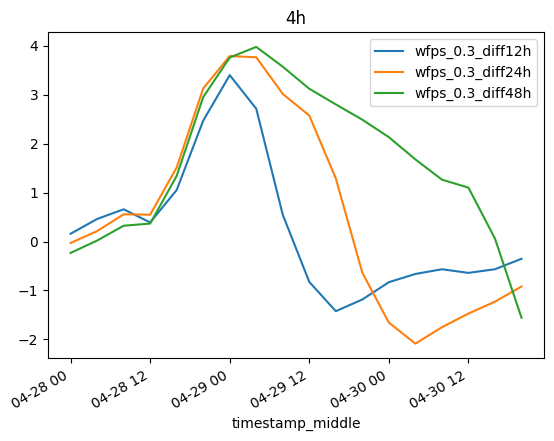

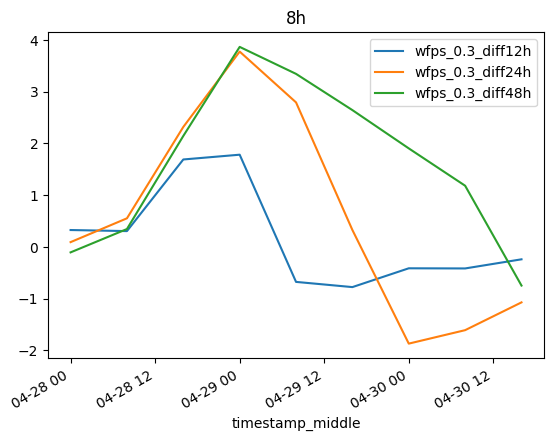

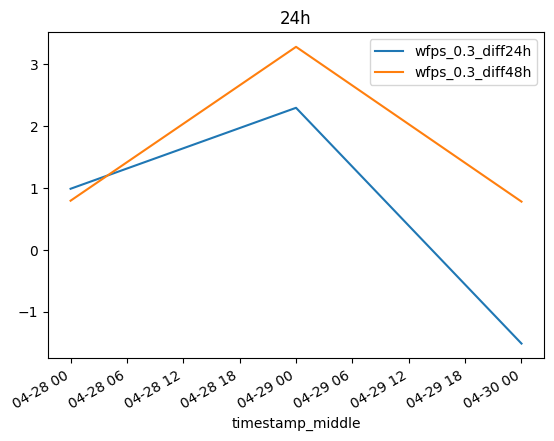

In [39]:
# Define interval of records for the difference calculation
intervals = [12, 24, 48] # in hours

# Loop through the dictionary
for name, df in dfs.items():

    # Identify the time resolution in hours of the dataframe
    time_res = float(name.replace('h', ''))

    # Prepare a list to hold new diff columns
    diff_columns = []

    # Copy relevant columns
    for v in _list_diff_vars:
        if v in df.columns:       
            # Calculate changes for selected vars
            for interval in intervals:
                interval_adjusted = int(interval/time_res)
                if interval_adjusted > 0:
                    var_diff = f'{v}_diff{interval}h'
                    diff_columns.append(df[v].diff(periods=interval_adjusted).rename(var_diff)) 

    # Concatenate all columns at once to avoid fragmentation
    _diff_data = pd.concat(diff_columns, axis=1)

    # Add only the lag columns to the original dataframe
    dfs[name] = pd.concat([df, _diff_data], axis=1)

    # Plot the lag vars for TA
    indat = dfs[name][[c for c in dfs[name].columns if 'wfps_0.3_diff' in c]]
    indat = indat.loc['2023-04-28':'2023-04-30']
    indat.plot(x_compat=True, title=name)  

## CUMULATIVE NEP

Create a new variable which is - (NEEcum) --> cumulative NEP (net ecosystem production)

**IMPORTANT:** the goal is to create a variable which represents the crop growing, therefore I set positive NEE to zero.

In [40]:
'''# Create a copy of the original dataframe
_cum_df = df['2022-10-01': '2023-10-03'].copy() # exclude grassland cuts

# Initialize variables
_cum_df['sowing'] = _cum_df['sowing'].fillna(0)
_cum_df['harvest'] = _cum_df['harvest'].fillna(0)
# Modify nee not to have positive values --> not interested in the respiration 
_cum_df.loc[_cum_df['flux_nee_mds'] > 0, 'flux_nee_mds'] = 0
# New column for cumulative net ecosystem production
_cum_df['cum_nep'] = 0.0 # float

# Find indices where sowing and harvest occur
sowing_indices = _cum_df[_cum_df['sowing'] == 1].index.tolist()
harvest_indices = _cum_df[_cum_df['harvest'] == 1].index.tolist()  

# Process each sowing-harvest pair and accumulate the cumulative NEP
for sowing_idx, harvest_idx in zip(sowing_indices, harvest_indices):
    # Slice the DataFrame between sowing and harvest
    df_slice = _cum_df.loc[sowing_idx:harvest_idx, 'flux_nee_mds']
    # Apply cumulative sum and store it in the new column, change sign if needed
    _cum_df.loc[sowing_idx:harvest_idx, 'cum_nep'] = -df_slice.cumsum()

# Keep only the created column
_cum_df = _cum_df['cum_nep']

# Plot the result using the copied dataframe
_cum_df.plot(x_compat=True);

# Show df
_cum_df
'''

"# Create a copy of the original dataframe\n_cum_df = df['2022-10-01': '2023-10-03'].copy() # exclude grassland cuts\n\n# Initialize variables\n_cum_df['sowing'] = _cum_df['sowing'].fillna(0)\n_cum_df['harvest'] = _cum_df['harvest'].fillna(0)\n# Modify nee not to have positive values --> not interested in the respiration \n_cum_df.loc[_cum_df['flux_nee_mds'] > 0, 'flux_nee_mds'] = 0\n# New column for cumulative net ecosystem production\n_cum_df['cum_nep'] = 0.0 # float\n\n# Find indices where sowing and harvest occur\nsowing_indices = _cum_df[_cum_df['sowing'] == 1].index.tolist()\nharvest_indices = _cum_df[_cum_df['harvest'] == 1].index.tolist()  \n\n# Process each sowing-harvest pair and accumulate the cumulative NEP\nfor sowing_idx, harvest_idx in zip(sowing_indices, harvest_indices):\n    # Slice the DataFrame between sowing and harvest\n    df_slice = _cum_df.loc[sowing_idx:harvest_idx, 'flux_nee_mds']\n    # Apply cumulative sum and store it in the new column, change sign if need


Add created additional variable to the main dataframe

In [41]:
# Add to main data
#df = pd.concat([df, _cum_df], axis=1)

# EXPORT DATA

## CLEAN DATAFRAMES

In [42]:
for name, df in dfs.items():
    # Drop rows where the index is NaT (missing timestamp)
    dfs[name] = df[df.index.notna()]
    print(f"Rows without a valid index have been removed from DataFrame '{name}'.")

Rows without a valid index have been removed from DataFrame '0.5h'.
Rows without a valid index have been removed from DataFrame '4h'.
Rows without a valid index have been removed from DataFrame '8h'.
Rows without a valid index have been removed from DataFrame '24h'.


## DEFINE TIME RANGE

In [43]:
start_date = '2021-01-01'
end_date = '2023-12-31'
for name, df in dfs.items():
    # Filter the DataFrame by the date range and update it
    dfs[name] = df[start_date:end_date]
    print(f"DataFrame '{name}' has been filtered to the date range {start_date} to {end_date}.")

DataFrame '0.5h' has been filtered to the date range 2021-01-01 to 2023-12-31.
DataFrame '4h' has been filtered to the date range 2021-01-01 to 2023-12-31.
DataFrame '8h' has been filtered to the date range 2021-01-01 to 2023-12-31.
DataFrame '24h' has been filtered to the date range 2021-01-01 to 2023-12-31.


## CHECKS

Check what columns are contained in the final dataset

In [44]:
# Loop through each DataFrame in the `dfs` dictionary
for name, df in dfs.items():
    print(f'Dataframe {name} contains {len(df.columns)} columns: {sorted(df.columns)}')

Dataframe 0.5h contains 238 columns: ['can_height', 'crop_c', 'crop_n', 'crop_type', 'fert', 'fert_timed', 'flux_ch4_qcf_f_rf', 'flux_ch4_qcf_f_rf_lag12h', 'flux_ch4_qcf_f_rf_lag24h', 'flux_ch4_qcf_f_rf_lag48h', 'flux_ch4_qcf_f_rf_roll12hmean', 'flux_ch4_qcf_f_rf_roll24hmean', 'flux_ch4_qcf_f_rf_roll48hmean', 'flux_gpp', 'flux_gpp_lag12h', 'flux_gpp_lag24h', 'flux_gpp_lag48h', 'flux_gpp_roll12hsum', 'flux_gpp_roll24hsum', 'flux_gpp_roll48hsum', 'flux_h_qcf_f_mds', 'flux_h_qcf_f_mds_lag12h', 'flux_h_qcf_f_mds_lag24h', 'flux_h_qcf_f_mds_lag48h', 'flux_h_qcf_f_mds_roll12hmean', 'flux_h_qcf_f_mds_roll24hmean', 'flux_h_qcf_f_mds_roll48hmean', 'flux_le_qcf_f_mds', 'flux_le_qcf_f_mds_lag12h', 'flux_le_qcf_f_mds_lag24h', 'flux_le_qcf_f_mds_lag48h', 'flux_le_qcf_f_mds_roll12hmean', 'flux_le_qcf_f_mds_roll24hmean', 'flux_le_qcf_f_mds_roll48hmean', 'flux_n2o_qcf', 'flux_n2o_qcf0', 'flux_n2o_qcf0_lag12h', 'flux_n2o_qcf0_lag24h', 'flux_n2o_qcf0_lag48h', 'flux_n2o_qcf0_roll12hmean', 'flux_n2o_qcf0_r

Check the timestamp

In [45]:
for name, df in dfs.items():
    # Generate the complete timestamp range
    start_date = df.index.min()
    end_date = df.index.max()
    # Identify the time resolution in hours of the dataframe
    if name == '0.5h':
        complete_timestamp = pd.date_range(start=start_date, end=end_date, freq='30min')
    else:
        complete_timestamp = pd.date_range(start=start_date, end=end_date, freq=name)

    # Compare the complete range with the dataframe's index
    missing_timestamps = complete_timestamp.difference(df.index)
    duplicate_timestamps = df.index[df.index.duplicated()]

    print()
    print(f'Dataframe at {name} time resolution:')
    print()

    # Output the duplicate and missing timestamps
    if not duplicate_timestamps.empty:
        print("Duplicate Timestamps:")
        print(duplicate_timestamps)
    else:
        print("No duplicate timestamps found.")

    if not missing_timestamps.empty:
        print("Missing Timestamps:")
        print(missing_timestamps)
    else:
        print("No missing timestamps found.")

    # Check if the timestamp is complete and has no duplicates
    if duplicate_timestamps.empty and missing_timestamps.empty:
        print("The timestamp index is complete and has no duplicates.")
    else:
        print("The timestamp index has issues.")


Dataframe at 0.5h time resolution:

No duplicate timestamps found.
No missing timestamps found.
The timestamp index is complete and has no duplicates.

Dataframe at 4h time resolution:

No duplicate timestamps found.
No missing timestamps found.
The timestamp index is complete and has no duplicates.

Dataframe at 8h time resolution:

No duplicate timestamps found.
No missing timestamps found.
The timestamp index is complete and has no duplicates.

Dataframe at 24h time resolution:

No duplicate timestamps found.
No missing timestamps found.
The timestamp index is complete and has no duplicates.


## SAVE FILES

In [46]:
for name, df in dfs.items():
    df.to_csv(f'data/03-final_dataset_{name}.csv', index=True)

# **End of notebook**

In [47]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2025-07-30 17:28:32
